<center>
<h1> Online news popularity (CEU-ML 2025) </h1>
<h2> Data Science 1: Machine Learning Tools </h2>
<h3>Azizbek Ussenov</h3>
<h4>2024-2025</h4>
</center>

(*) Note: This notebook presents the final version of my work. It focuses on the preprocessing steps and model choices that led to a public AUC score of 0.7385, without including all previous experiments. This is done to keep the notebook clean, concise, and easy to follow.
I hope this does not affect the evaluation of my work. I am happy to provide a detailed record of all my experiments upon request.

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.base import clone

## Data

In [91]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [93]:
df_train.head()

timedelta  n_tokens_title  n_tokens_content  n_unique_tokens  \
0        594               9               702         0.454545   
1        346               8              1197         0.470143   
2        484               9               214         0.618090   
3        639               8               249         0.621951   
4        177              12              1219         0.397841   

   n_non_stop_words  n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  \
0               1.0                  0.620438         11               2   
1               1.0                  0.666209         21               6   
2               1.0                  0.748092          5               2   
3               1.0                  0.664740         16               5   
4               1.0                  0.583578         21               1   

   num_imgs  num_videos  ...  max_positive_polarity  avg_negative_polarity  \
0         1           0  ...               1.000000              -0.153395   
1         2          13  ...               1.000000              -0.308167   
2         1           0  ...               0.433333              -0.141667   
3         8           0  ...               0.500000              -0.500000   
4         1           2  ...               0.800000              -0.441111   

   min_negative_polarity  max_negative_polarity  title_subjectivity  \
0                   -0.4                  -0.10                 0.0   
1                   -1.0                  -0.10                 0.0   
2                   -0.2                  -0.05                 0.0   
3                   -0.8                  -0.40                 0.0   
4                   -1.0                  -0.05                 0.0   

   title_sentiment_polarity  abs_title_subjectivity  \
0                       0.0                     0.5   
1                       0.0                     0.5   
2                       0.0                     0.5   
3                       0.0                     0.5   
4                       0.0                     0.5   

   abs_title_sentiment_polarity  is_popular  article_id  
0                           0.0           0           1  
1                           0.0           0           3  
2                           0.0           0           5  
3                           0.0           0           6  
4                           0.0           0           7  

[5 rows x 61 columns]

In [94]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29733 entries, 0 to 29732
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timedelta                      29733 non-null  int64  
 1   n_tokens_title                 29733 non-null  int64  
 2   n_tokens_content               29733 non-null  int64  
 3   n_unique_tokens                29733 non-null  float64
 4   n_non_stop_words               29733 non-null  float64
 5   n_non_stop_unique_tokens       29733 non-null  float64
 6   num_hrefs                      29733 non-null  int64  
 7   num_self_hrefs                 29733 non-null  int64  
 8   num_imgs                       29733 non-null  int64  
 9   num_videos                     29733 non-null  int64  
 10  average_token_length           29733 non-null  float64
 11  num_keywords                   29733 non-null  int64  
 12  data_channel_is_lifestyle      29733 non-null 

From the above information, I see that all columns are non-null, so no missing value handling is needed.

Let's check for class imbalance in target feature, as it is common practice to have class imbalance.

In [97]:
df_train['is_popular'].value_counts()

is_popular
0    26116
1     3617
Name: count, dtype: int64

Clearly, there is a class imbalance. However, I will not handle this because I tried to handle it with SMOTE and ADASYN, but the AUC score were lower than with class imbalance. So, I will use target variable as it is without any prerocessing.

Let's inspect which features are highly correlated and are candidate for dropping. I am settting threshold of 0.9 for high correlation in this case (it is usual practice)

In [98]:
corr_matrix =df_train.drop(columns=['is_popular']).corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print("Highly correlated columns:", to_drop)

Highly correlated columns: ['n_non_stop_words', 'n_non_stop_unique_tokens', 'kw_avg_min']


In [99]:
df_train[['n_non_stop_words', 'n_non_stop_unique_tokens', 'kw_avg_min', 'is_popular']].corr()


n_non_stop_words  n_non_stop_unique_tokens  \
n_non_stop_words                  1.000000                  0.999649   
n_non_stop_unique_tokens          0.999649                  1.000000   
kw_avg_min                       -0.001199                 -0.001029   
is_popular                        0.014546                  0.013991   

                          kw_avg_min  is_popular  
n_non_stop_words           -0.001199    0.014546  
n_non_stop_unique_tokens   -0.001029    0.013991  
kw_avg_min                  1.000000    0.023293  
is_popular                  0.023293    1.000000

I removed `n_non_stop_words` and `n_non_stop_unique_tokens` due to their high multicollinearity (r = 0.9996), and dropped `kw_avg_min` because its correlation with the target variable (is_popular) was very low (r = 0.023), suggesting limited predictive value. Removing these features helped reduce redundancy and improve model generalization.

In [100]:
df_train.drop(columns=['n_non_stop_words', 'n_non_stop_unique_tokens', 'kw_avg_min'], inplace=True)
df_test.drop(columns=['n_non_stop_words', 'n_non_stop_unique_tokens', 'kw_avg_min'], inplace=True)

Let's now inspect the distributions of all variables

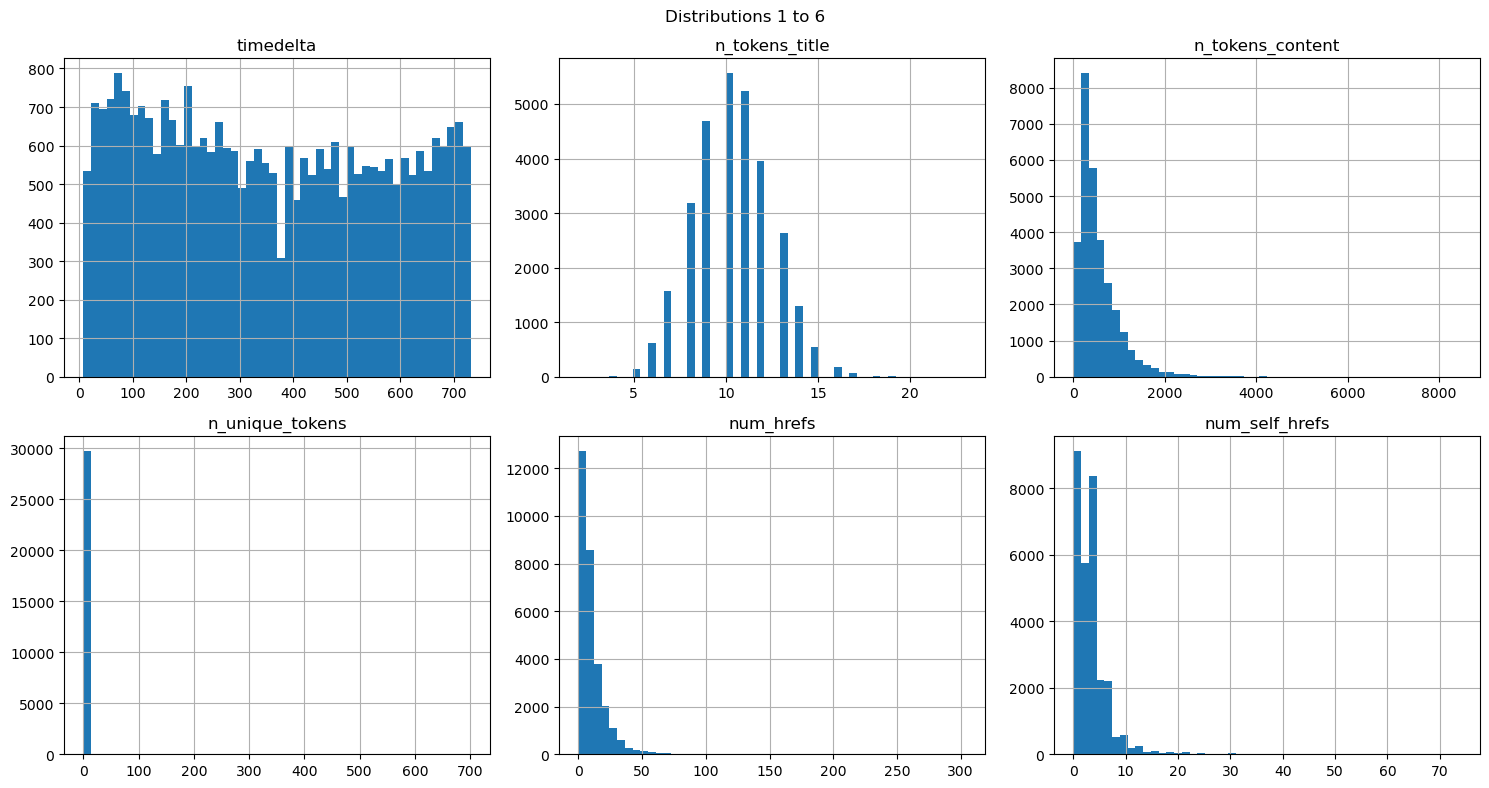

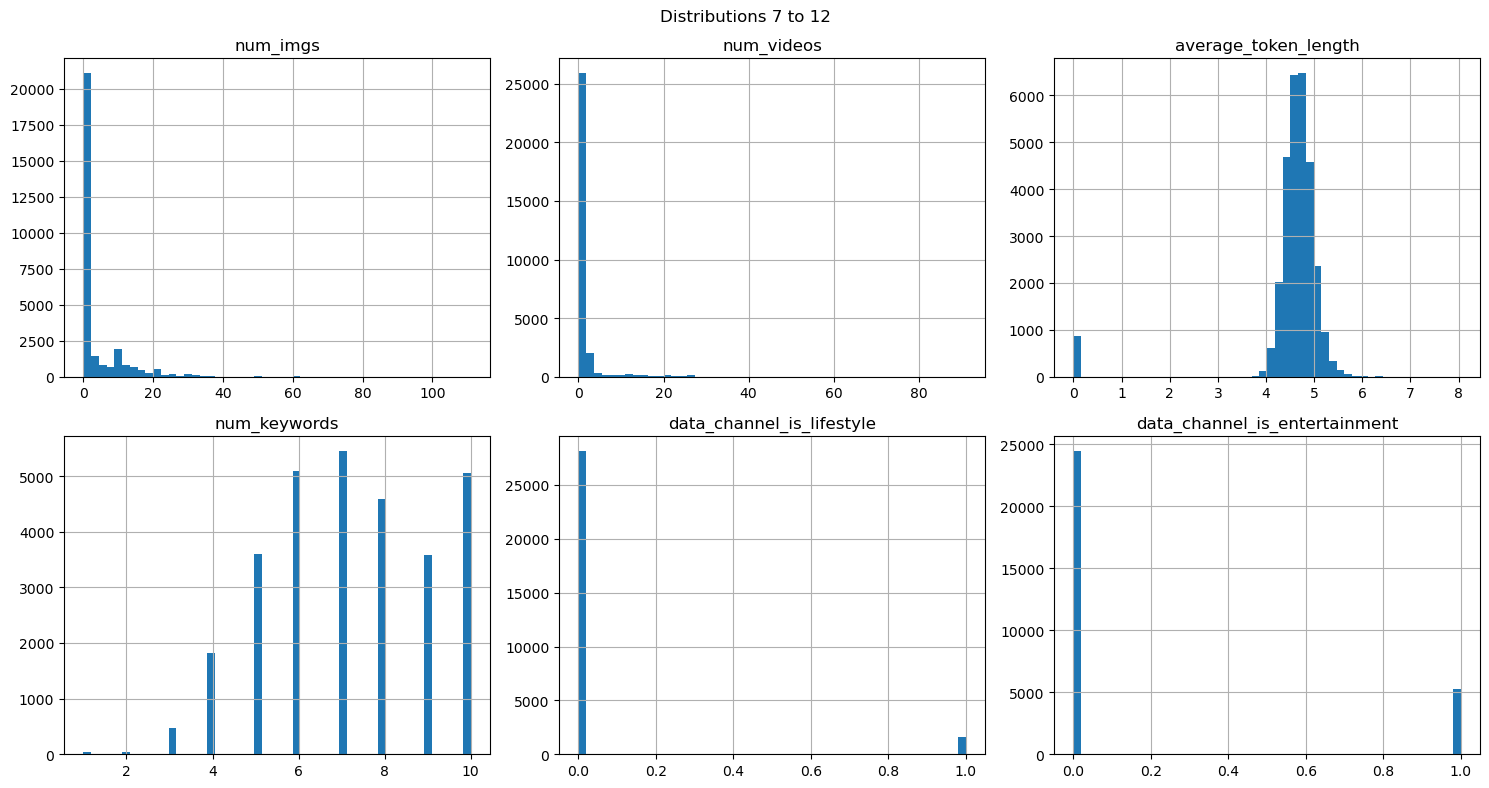

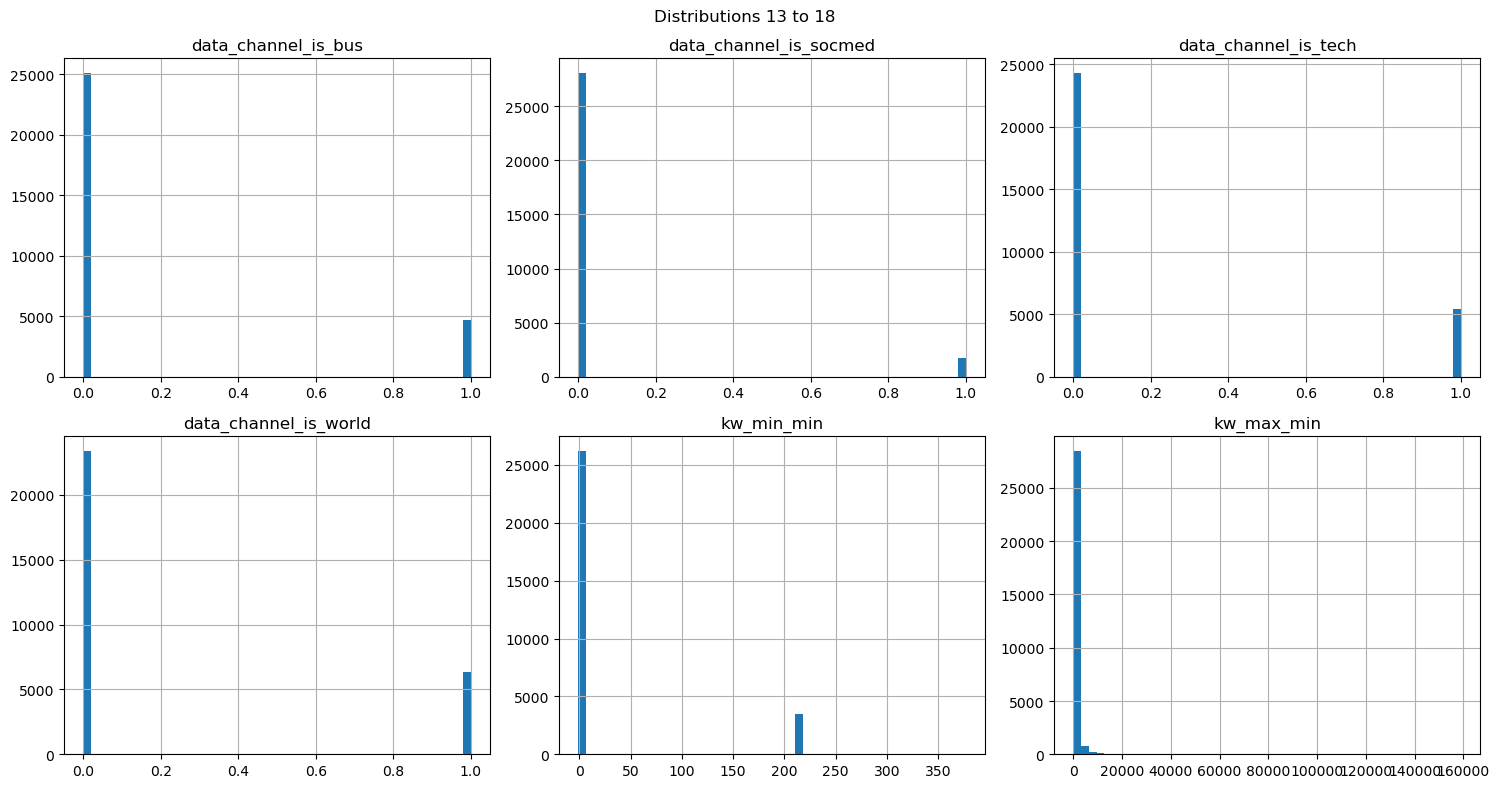

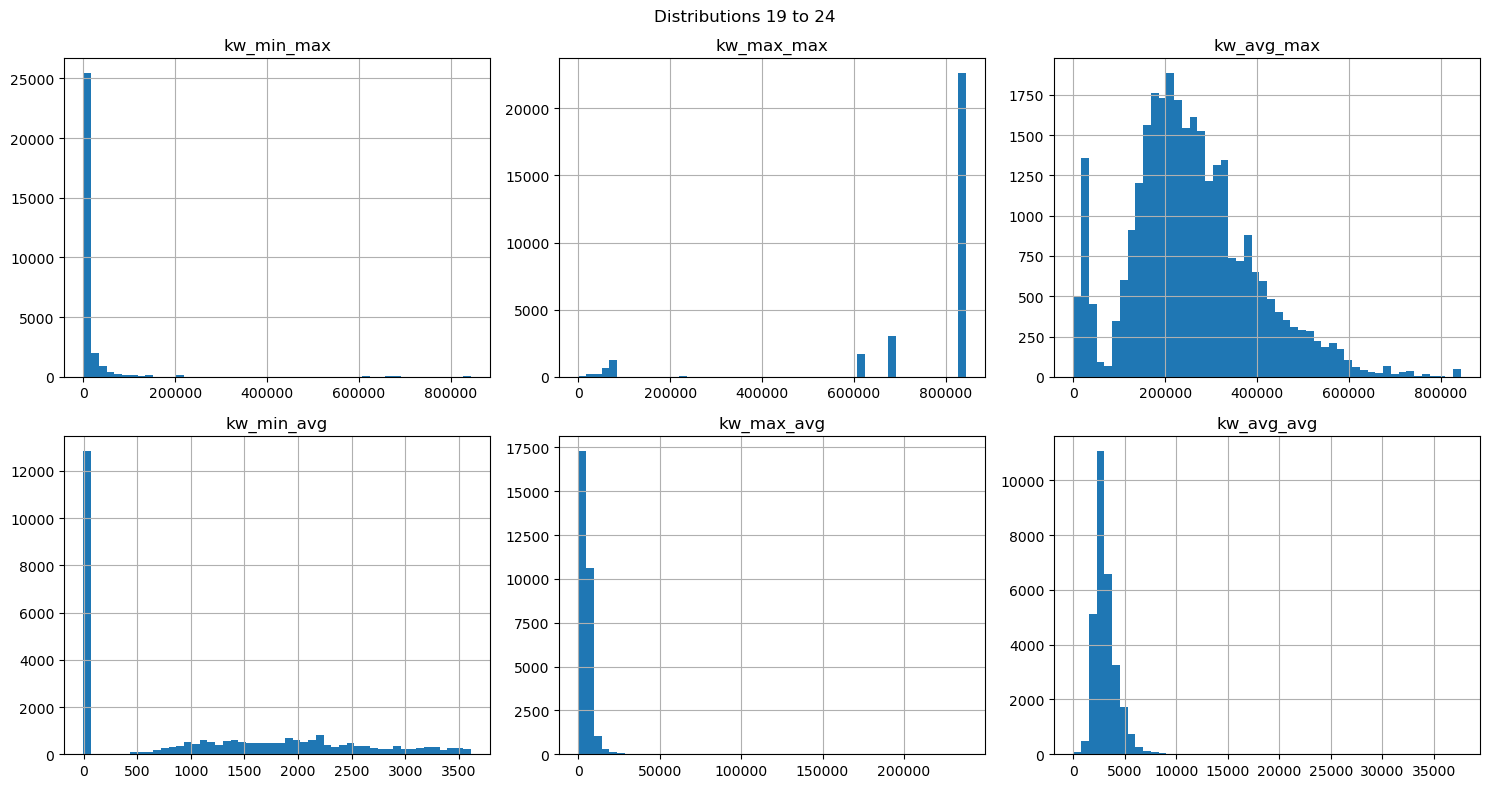

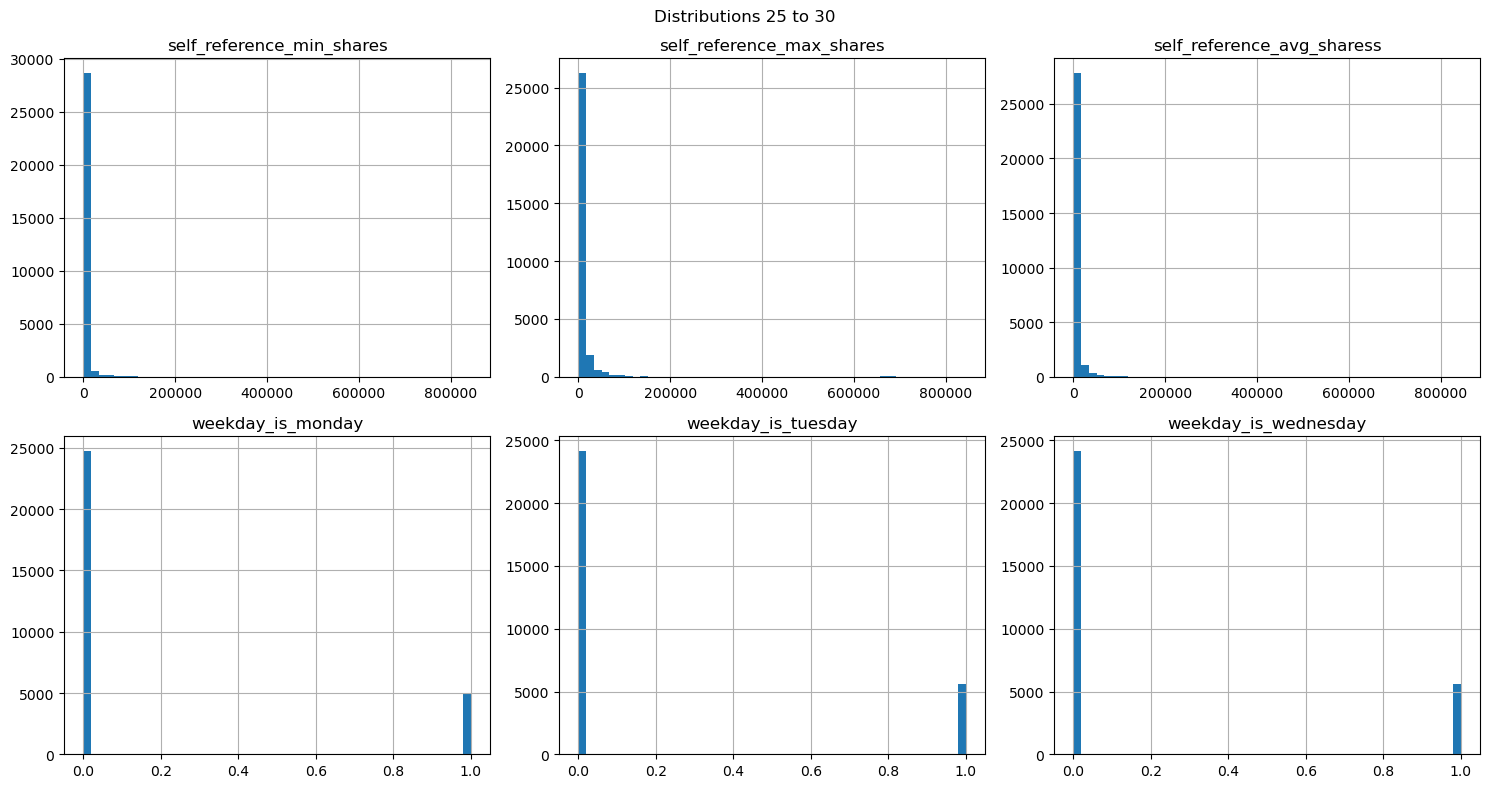

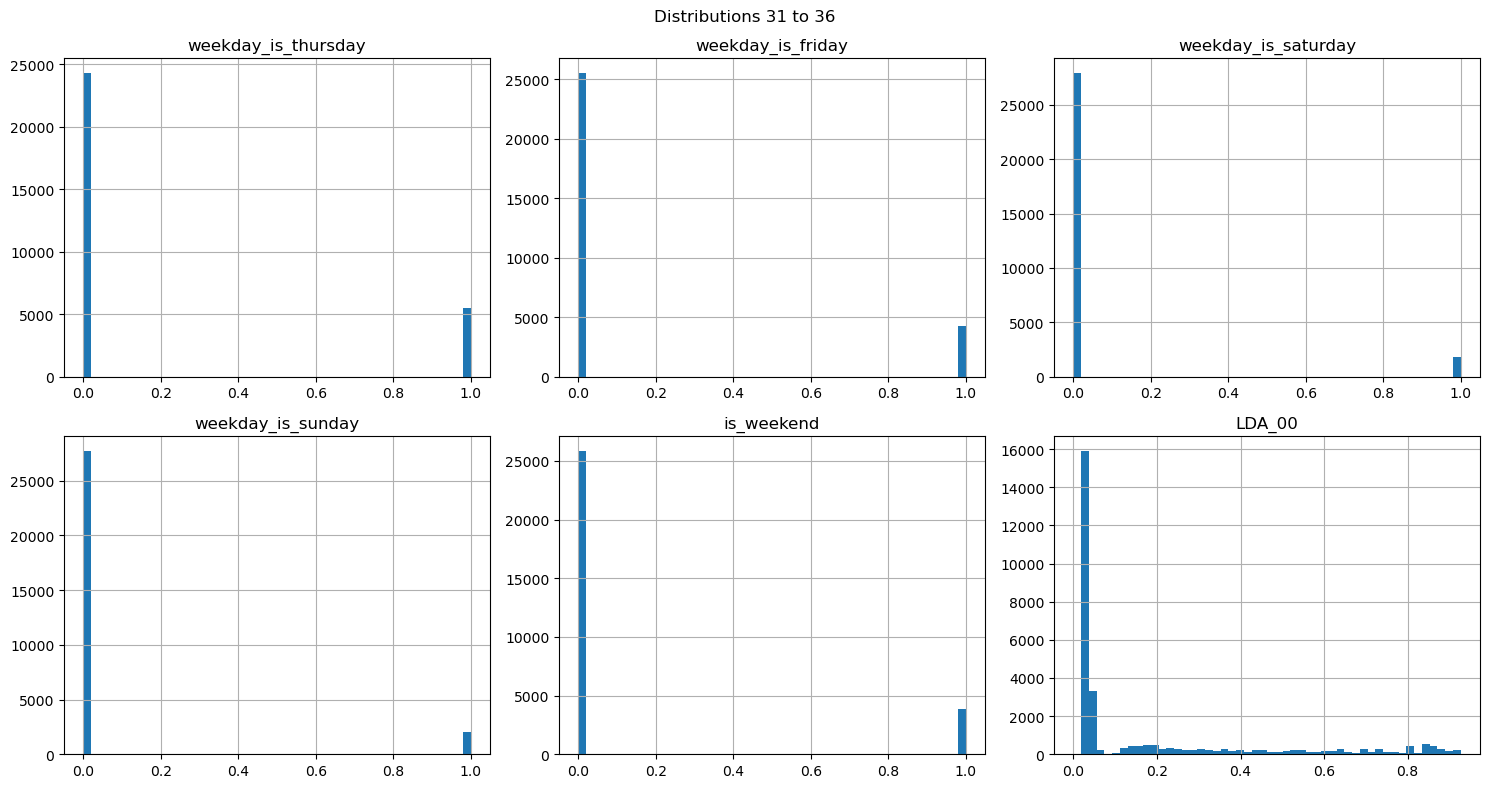

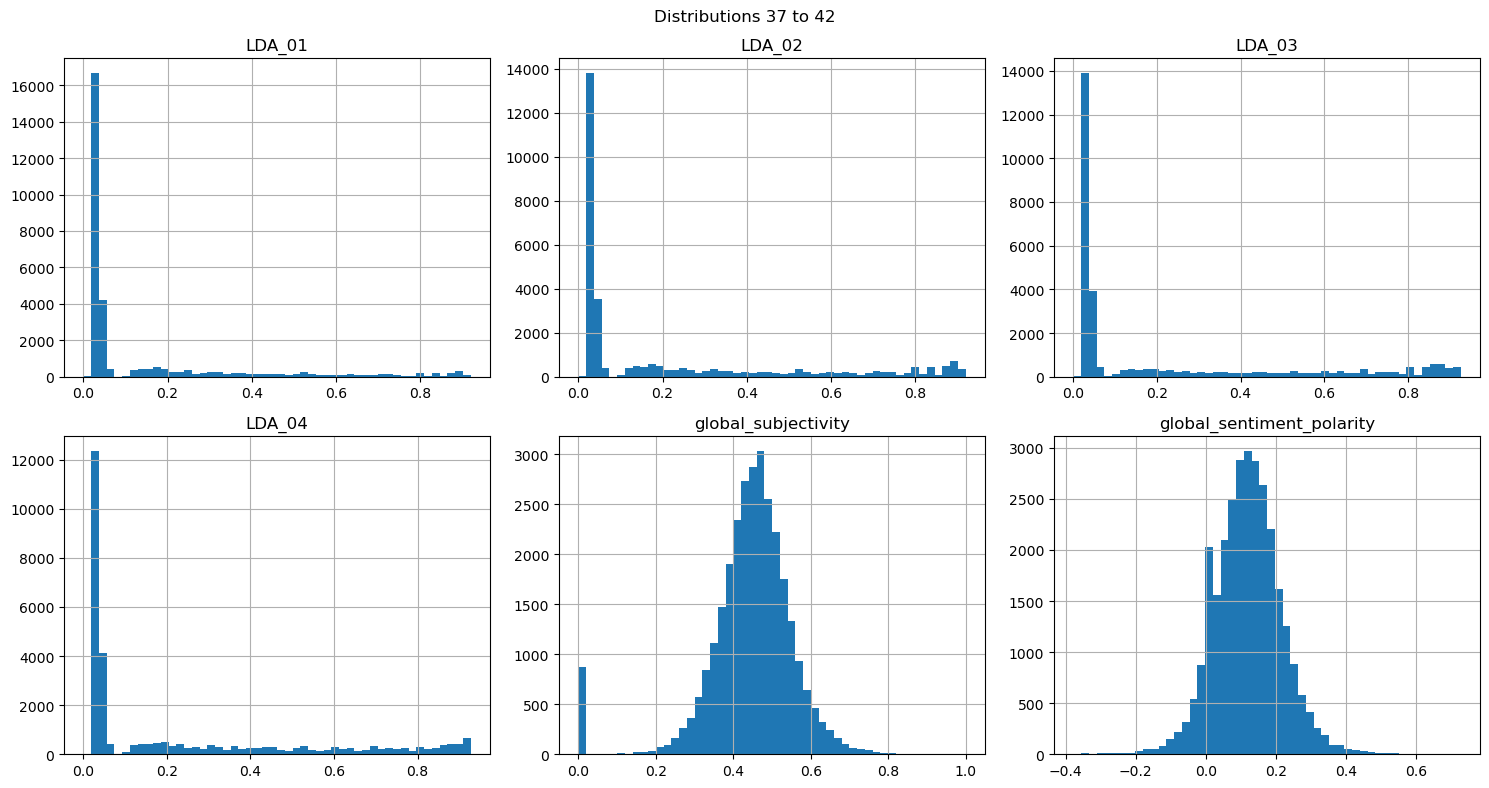

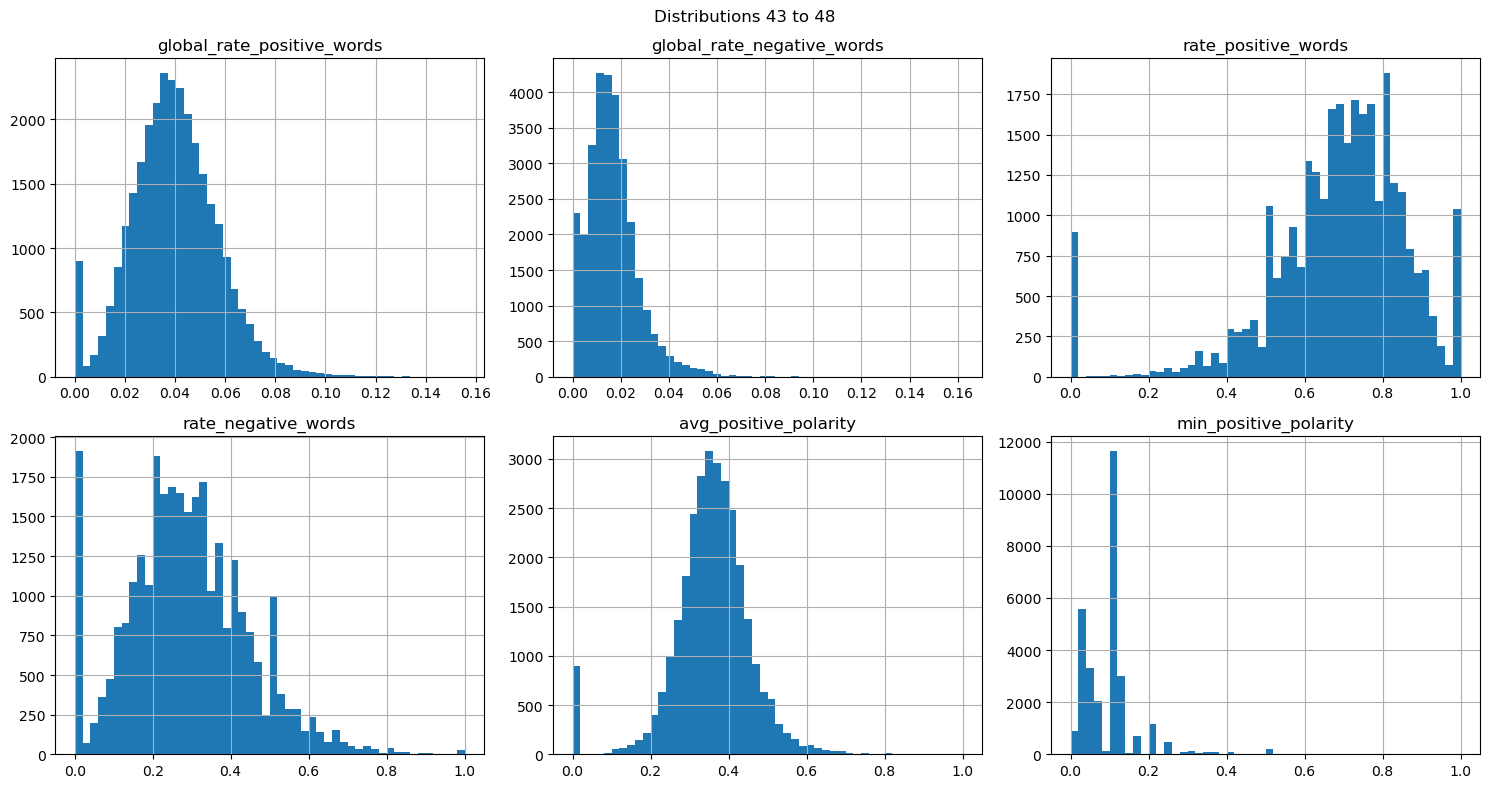

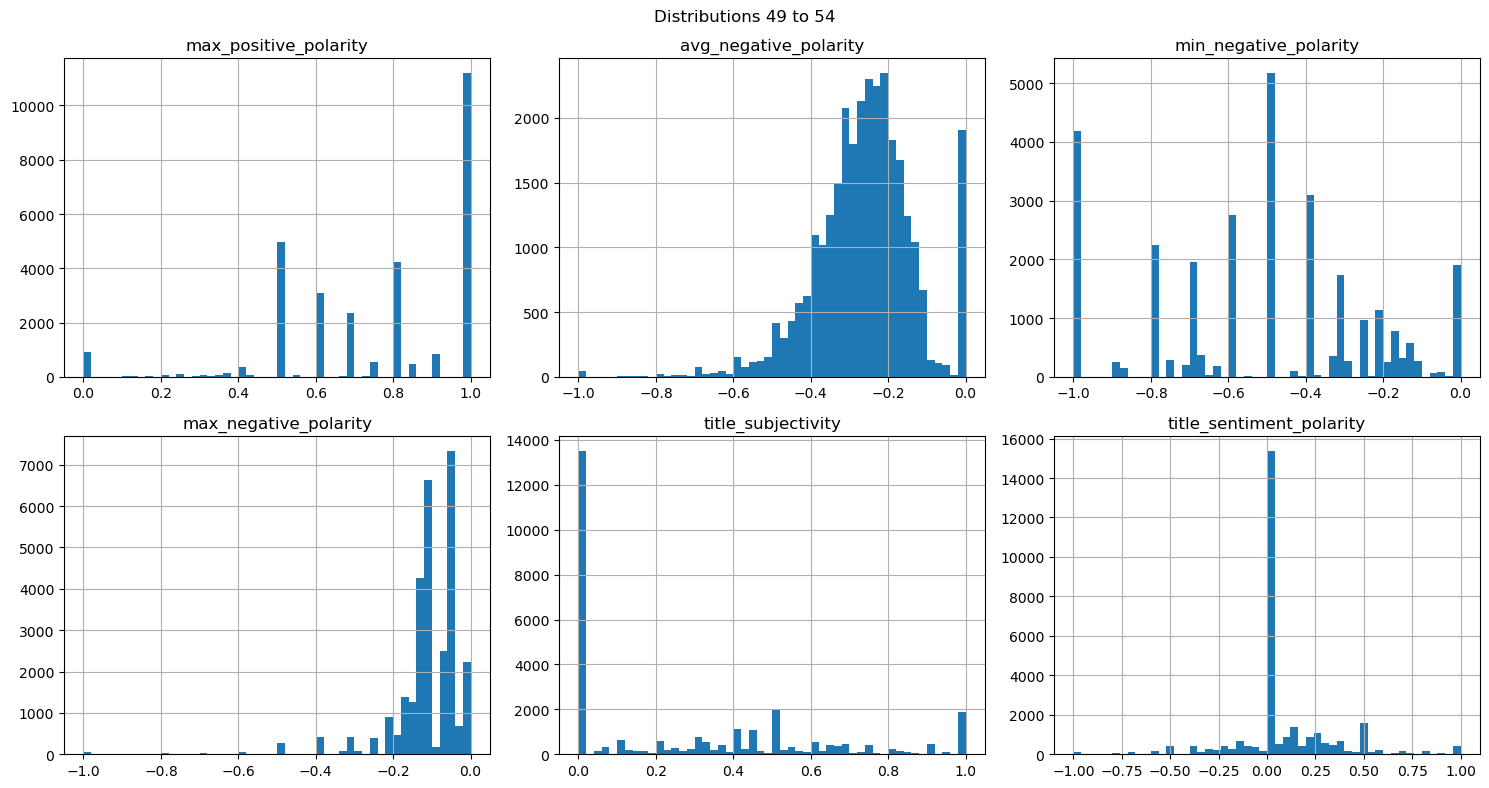

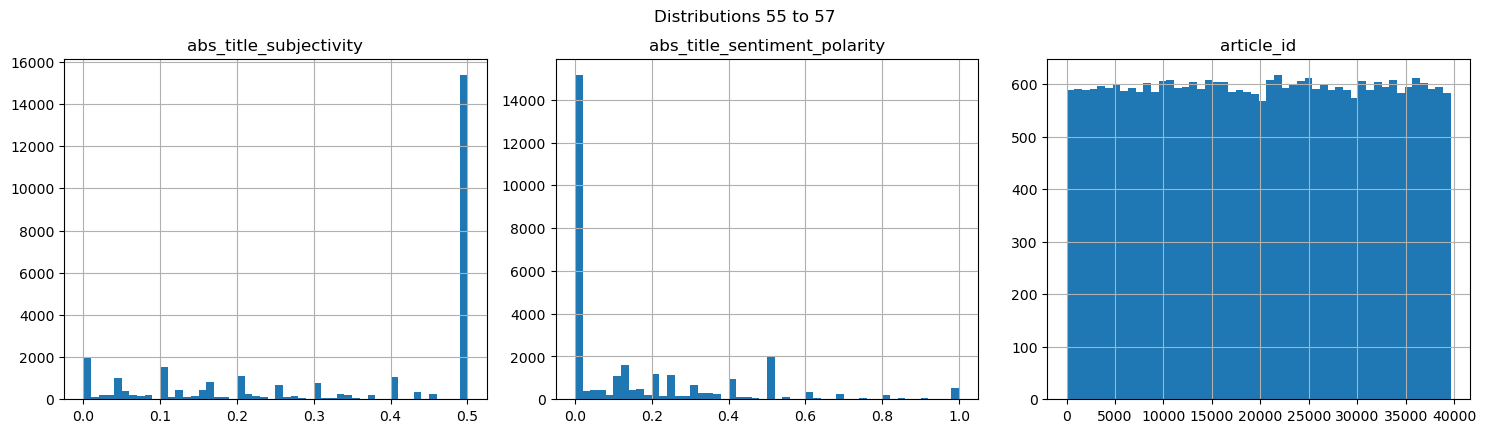

In [101]:
numeric_cols = df_train.select_dtypes(include=['float64', 'int64']).columns.drop('is_popular') 

batch_size = 6
for i in range(0, len(numeric_cols), batch_size):
    cols = numeric_cols[i:i+batch_size]
    df_train[cols].hist(bins=50, figsize=(15, 8), layout=(2, 3))
    plt.suptitle(f"Distributions {i+1} to {i+len(cols)}")
    plt.tight_layout()
    plt.show()

In [102]:
def get_skewed_features(df, exclude_cols=None, skew_threshold=0.5, absolute=True, show_skew=False):
    if exclude_cols is None:
        exclude_cols = []

    num_features = df.select_dtypes(include=['number']).columns.tolist()
    numeric_features = [feat for feat in num_features if feat not in exclude_cols]

    skewed = df[numeric_features].apply(lambda x: x.dropna().skew())

    if absolute:
        skewed_filtered = skewed[skewed.abs() > skew_threshold]
    else:
        skewed_filtered = skewed[skewed > skew_threshold]

    if show_skew:
        print("\nSkewed Features (threshold = {}):\n".format(skew_threshold))
        print(skewed_filtered.sort_values(ascending=False))

    return skewed_filtered.index.tolist()


In [103]:
skewed_feats = get_skewed_features(df_train, exclude_cols=['is_popular'], skew_threshold=0.5, show_skew=True)


Skewed Features (threshold = 0.5):

n_unique_tokens                  172.140221
self_reference_min_shares         26.064138
kw_max_min                        21.965290
self_reference_avg_sharess        17.822735
self_reference_max_shares         13.781038
kw_max_avg                        13.497083
kw_min_max                        10.419825
num_videos                         7.126248
kw_avg_avg                         5.430948
num_self_hrefs                     4.784756
num_hrefs                          4.056451
data_channel_is_lifestyle          3.982990
num_imgs                           3.857264
data_channel_is_socmed             3.797349
weekday_is_saturday                3.611783
weekday_is_sunday                  3.425730
min_positive_polarity              3.041707
n_tokens_content                   2.941979
kw_min_min                         2.365014
is_weekend                         2.190063
LDA_01                             2.088938
weekday_is_friday                  2.03

In [104]:
binary_cols = [col for col in skewed_feats if df_train[col].dropna().nunique() == 2]

numeric_cols = [col for col in skewed_feats if col not in binary_cols + ['is_popular']]

Some features exhibited skewed distributions, which can negatively impact model performance, especially for models sensitive to feature scaling like logistic regression. To address this, I applied power transformations to approximate normality and stabilize variance. I applied power transformation to reduce skewness, normalize feature distributions, and stabilize variance, which can improve model convergence and performance.

In [105]:
pt = PowerTransformer(method='yeo-johnson')
df_train[numeric_cols] = pt.fit_transform(df_train[numeric_cols])
df_test[numeric_cols] = pt.transform(df_test[numeric_cols])

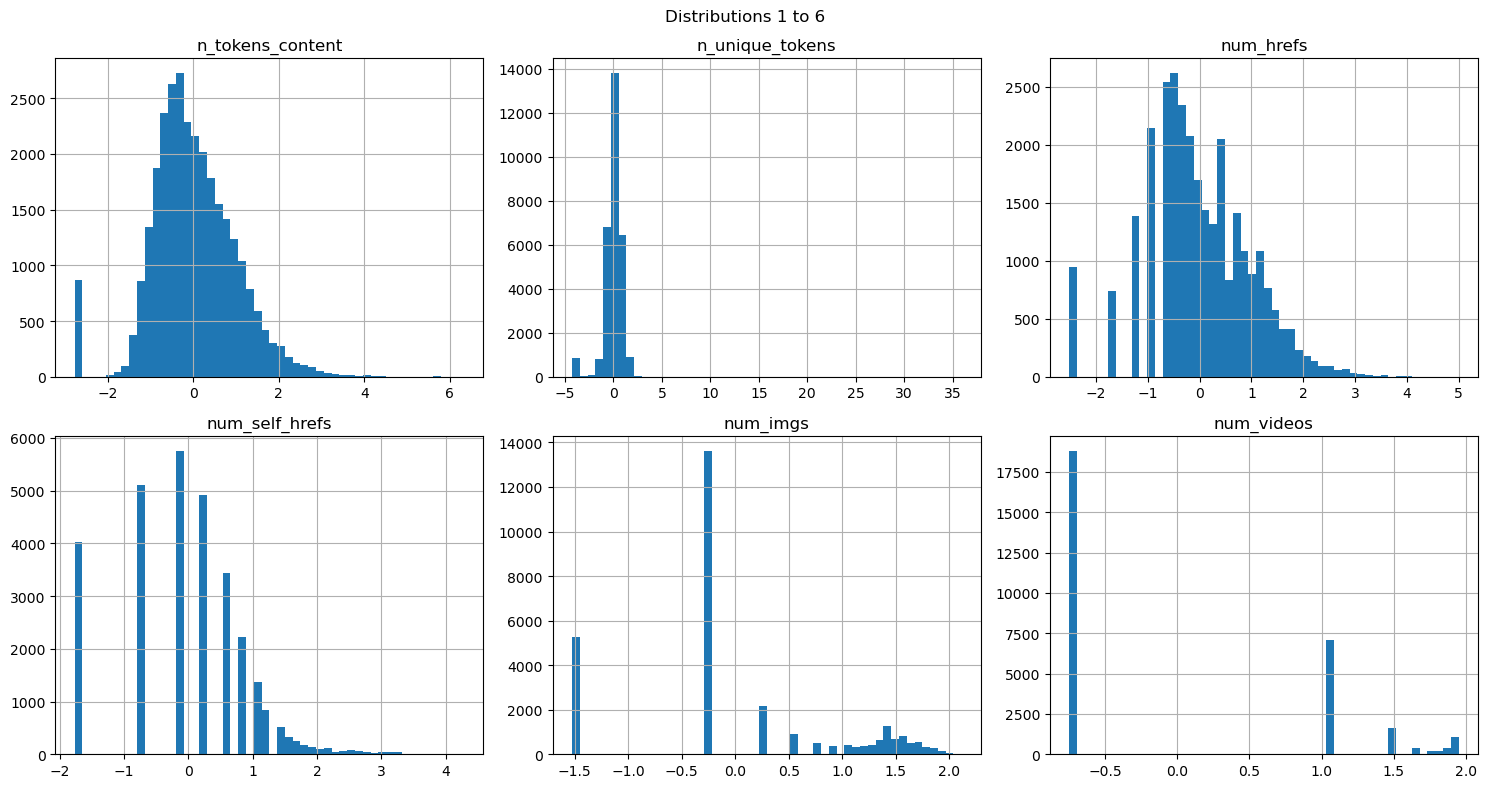

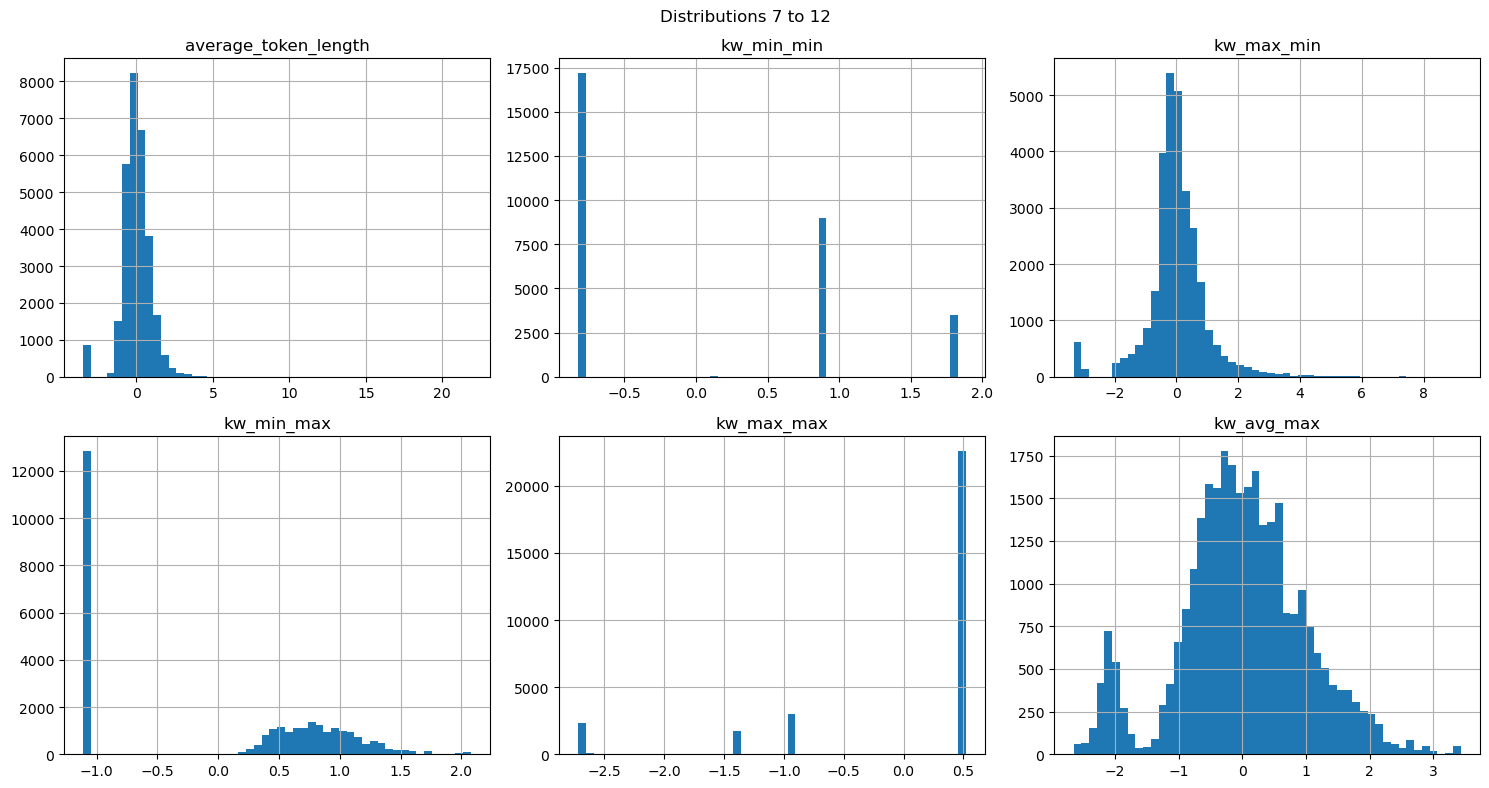

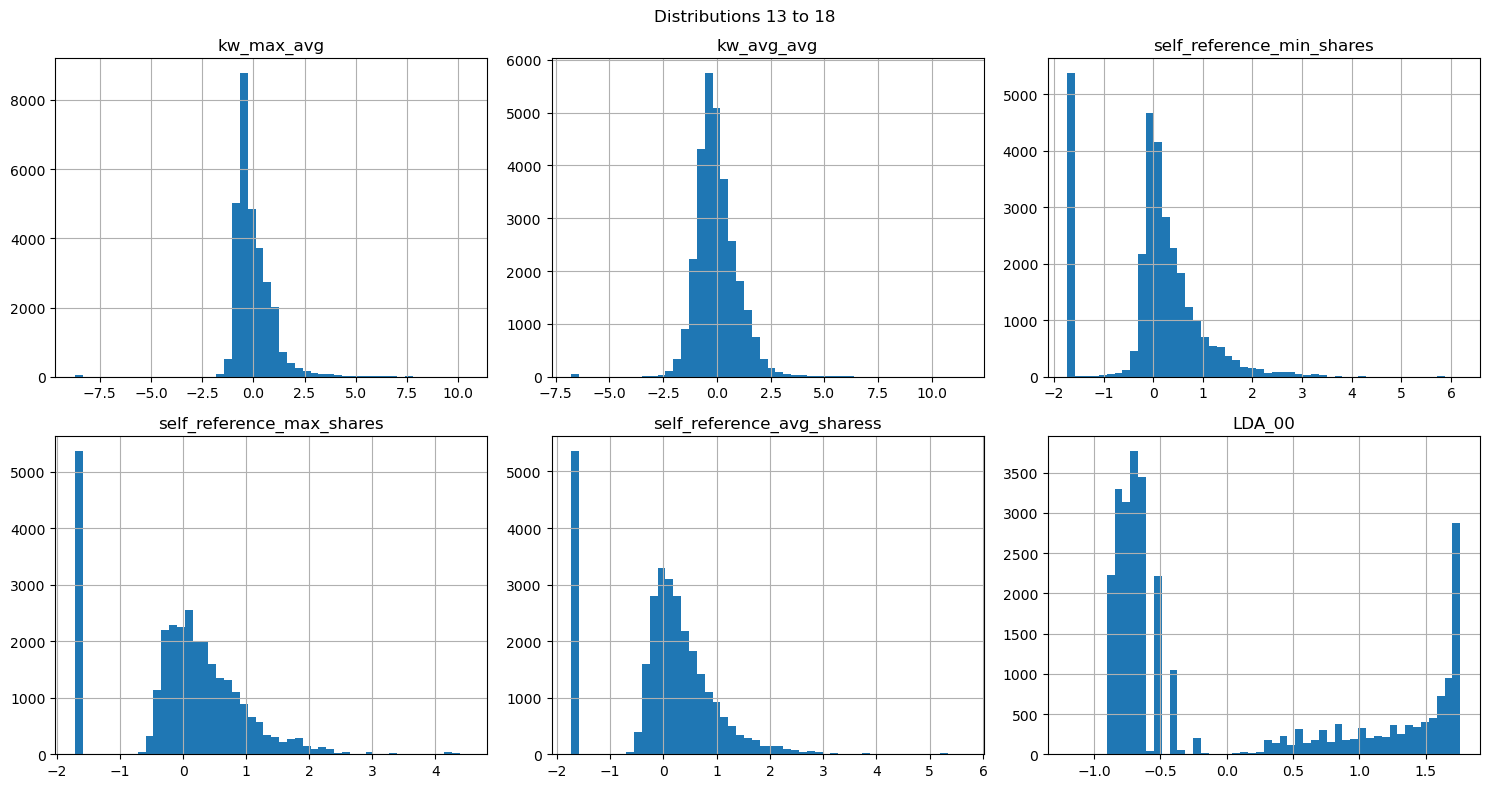

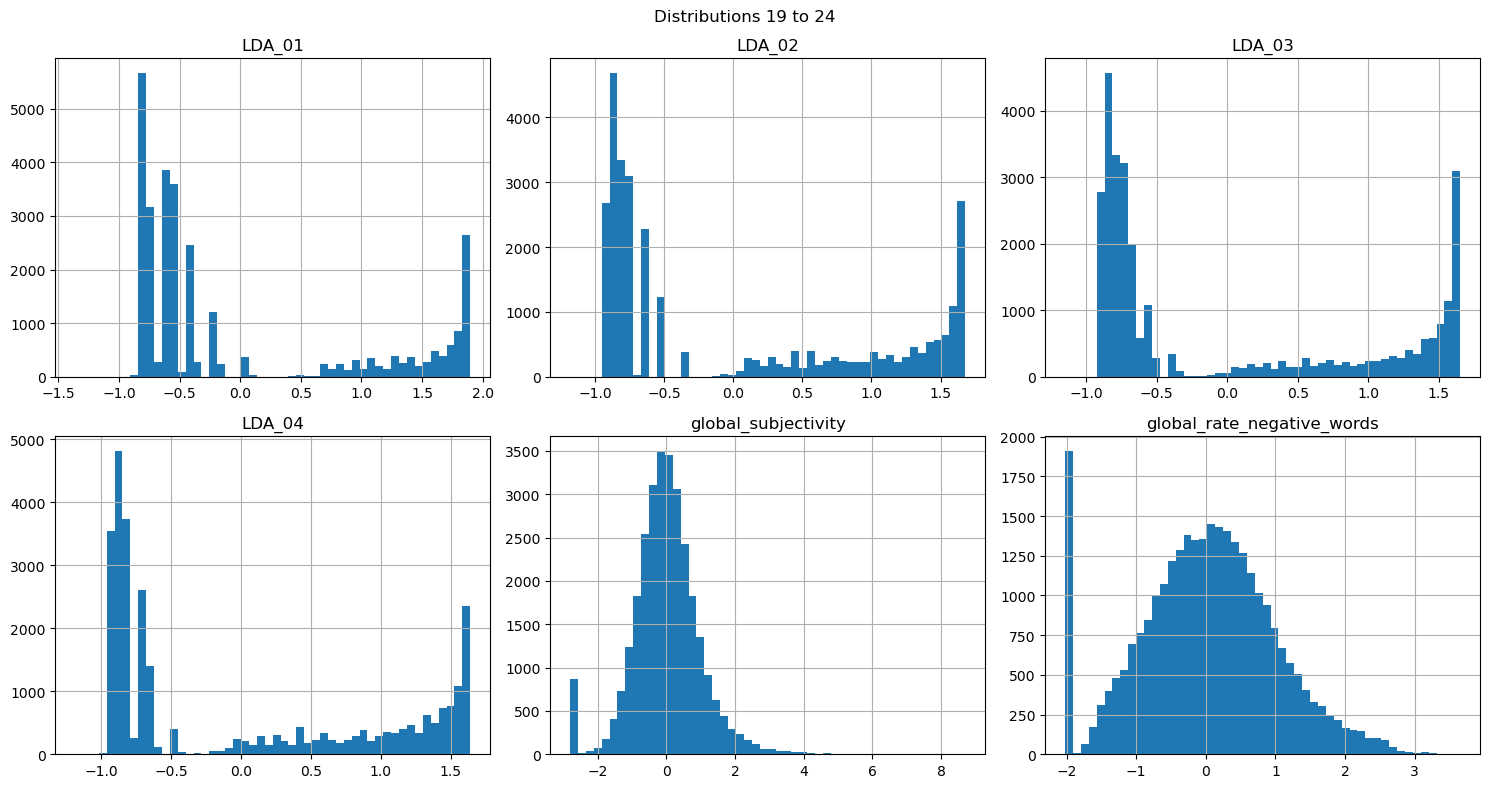

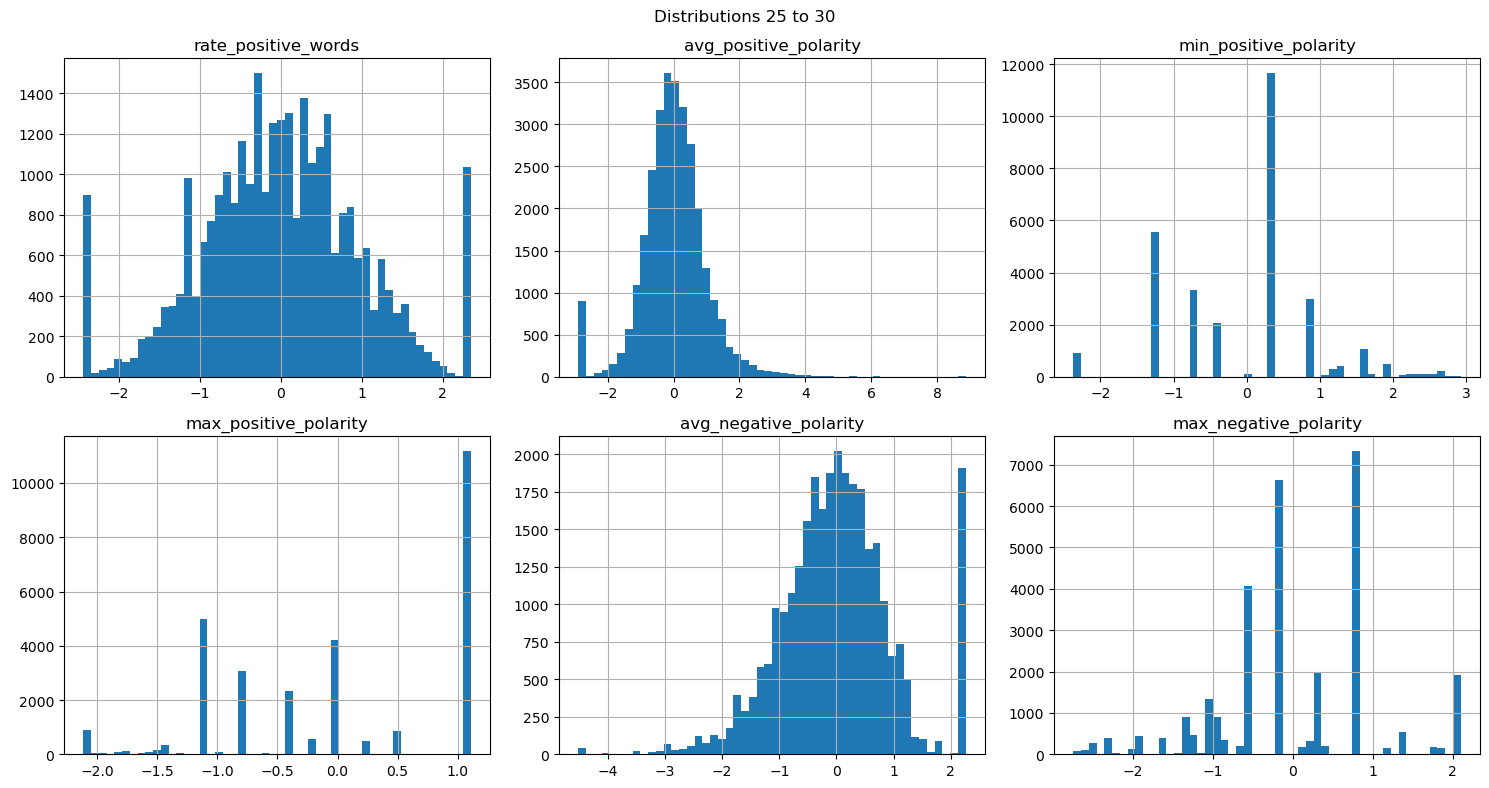

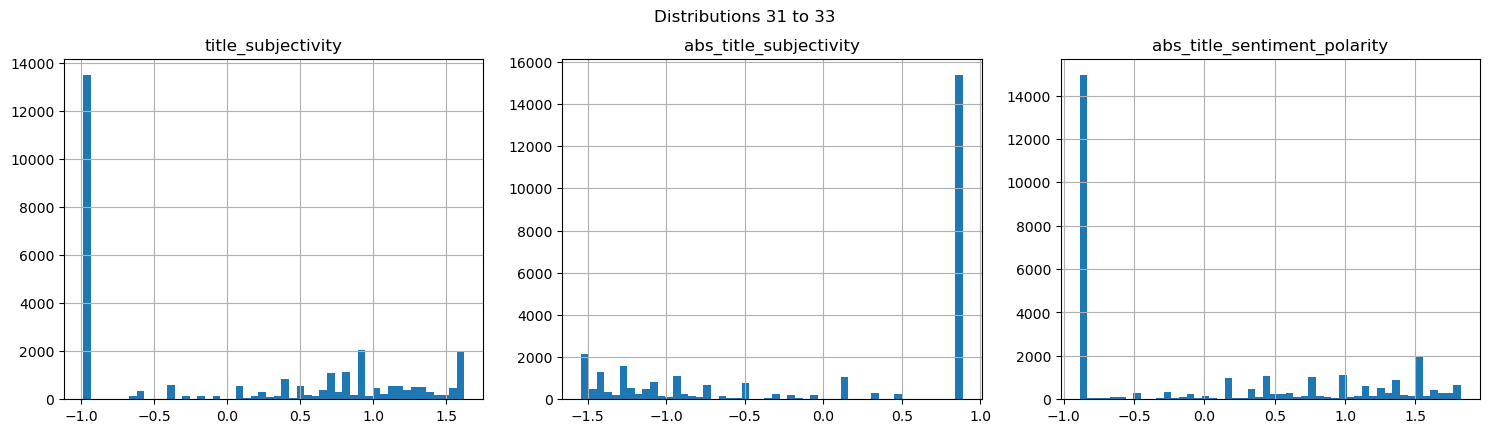

In [106]:
batch_size = 6
for i in range(0, len(numeric_cols), batch_size):
    cols = numeric_cols[i:i+batch_size]
    df_train[cols].hist(bins=50, figsize=(15, 8), layout=(2, 3))
    plt.suptitle(f"Distributions {i+1} to {i+len(cols)}")
    plt.tight_layout()
    plt.show()

After applying power transformations, many skewed features became more symmetric and closer to a normal distribution, improving compatibility with logistic regression, which assumes linearity and benefits from normalized input features. While a few features remained non-normal due to their discrete or zero-inflated nature, the transformation overall helped reduce skewness and stabilize variance, enhancing model performance and interpretability.

<hr>

Saving article_id variable for later submission

In [10]:
test_id = df_test[['article_id']].copy()

In [11]:
X_train = df_train.drop(columns=['is_popular', 'article_id'])
X_test = df_test.drop(columns=['article_id'])
y = df_train['is_popular']

### Feature Engineering

In [ ]:
def engineer_features(df):
    df = df.copy()

    # content quality / richness
    df['content_richness'] = df['n_tokens_content'] * df['n_unique_tokens']
    df['media_richness'] = (df['num_imgs'] + df['num_videos']) * df['average_token_length']
    df['link_density'] = (df['num_hrefs'] + df['num_self_hrefs']) / (df['n_tokens_content'] + 1)
    df['keywords_content_ratio'] = df['num_keywords'] / (df['n_tokens_content'] + 1)

    # temporal interactions
    df['weekend_tokens'] = df['is_weekend'] * df['n_tokens_content']
    df['weekday_avg_shares'] = (1 - df['is_weekend']) * df['self_reference_avg_sharess']
    df['weekday_kw_interaction'] = df['is_weekend'] * df['kw_avg_avg']

    # sentiment & subjectivity
    df['pos_sentiment_emphasis'] = df['global_rate_positive_words'] * df['global_sentiment_polarity']
    df['neg_sentiment_intensity'] = df['global_rate_negative_words'] * df['global_sentiment_polarity'].abs()
    df['subj_sentiment'] = df['global_subjectivity'] * df['global_sentiment_polarity']
    df['title_sentiment_interaction'] = df['title_subjectivity'] * df['title_sentiment_polarity']
    df['title_vs_content_sent_diff'] = (df['title_sentiment_polarity'] - df['global_sentiment_polarity']).abs()

    # keyword & share stats
    df['kw_shares_alignment'] = df['kw_avg_avg'] * df['self_reference_avg_sharess']
    df['kw_max_spread'] = df['kw_max_max'] - df['kw_min_min']
    df['self_ref_shares_range'] = df['self_reference_max_shares'] - df['self_reference_min_shares']
    df['kw_shares_variability'] = df['kw_avg_avg'] / (df['self_reference_avg_sharess'] + 1)

    # LDA & sentiment
    df['topic_sentiment_0'] = df['LDA_00'] * df['global_sentiment_polarity']
    df['topic_sentiment_1'] = df['LDA_01'] * df['global_rate_positive_words']
    df['topic_subjectivity_2'] = df['LDA_02'] * df['global_subjectivity']
    df['lda_sentiment_variance'] = (df['LDA_00'] + df['LDA_01'] + df['LDA_02'] + df['LDA_03'] + df['LDA_04']) * df['global_sentiment_polarity']

    # channel-specific behavior
    df['tech_kw_focus'] = df['data_channel_is_tech'] * df['kw_avg_avg']
    df['socmed_title_focus'] = df['data_channel_is_socmed'] * df['n_tokens_title']
    df['lifestyle_img_ratio'] = df['data_channel_is_lifestyle'] * df['num_imgs'] / (df['n_tokens_content'] + 1)
    df['entertainment_sent_bias'] = df['data_channel_is_entertainment'] * df['global_sentiment_polarity']

    # polarity spread
    df['pos_polarity_range'] = df['max_positive_polarity'] - df['min_positive_polarity']
    df['neg_polarity_range'] = df['max_negative_polarity'] - df['min_negative_polarity']
    df['polarization_strength'] = (df['pos_polarity_range'] + df['neg_polarity_range']) * df['global_subjectivity']

    # combined media/sentiment
    df['media_sentiment_combo'] = (df['num_imgs'] + df['num_videos']) * df['global_sentiment_polarity']
    df['title_polarity_focus'] = df['abs_title_sentiment_polarity'] * df['n_tokens_title']

    return df

1. Content Quality / Richness
    - Goal: Capture the depth and informativeness of an article.

    - Features like content_richness, media_richness, link_density, and keywords_content_ratio reflect how content is composed—richer articles with more unique words, media, links, or keyword density may attract higher engagement or signal more effortful content creation.

2. Temporal Interactions
    - Goal: Capture behavioral differences between weekdays and weekends.

    - Features such as weekend_tokens, weekday_avg_shares, and weekday_kw_interaction model how content structure and keyword interactions may vary in impact depending on the day of publication, acknowledging that audience behavior changes over the week.

3. Sentiment & Subjectivity
    - Goal: Measure emotional tone and subjectivity in both title and content.

    - Features like pos_sentiment_emphasis, neg_sentiment_intensity, subj_sentiment, and title_sentiment_interaction combine sentiment scores and subjectivity to model the emotional appeal and potential clickbait effects.

    - title_vs_content_sent_diff adds insight into whether there's a mismatch between headline tone and article body, which can influence sharing behavior.

4. Keyword & Share Stats
    - Goal: Capture relationships between keyword usage and sharing activity.

    - kw_shares_alignment, kw_max_spread, self_ref_shares_range, and kw_shares_variability reflect how keyword importance and variability relate to how widely the article is referenced or shared—potential indicators of virality or relevance.

5. LDA & Sentiment
    - Goal: Connect content topics with emotional and subjective tones.

    - topic_sentiment_0, topic_sentiment_1, and topic_subjectivity_2 assess whether certain latent topics are linked to positive language or subjective expression.

    - lda_sentiment_variance models the joint variability of topic presence and sentiment, possibly signaling polarized or emotionally charged content.

6. Channel-Specific Behavior
    - Goal: Capture interaction effects between content characteristics and media channels.

    - For example, tech_kw_focus assumes that keyword relevance is more important in tech-related articles, while socmed_title_focus and lifestyle_img_ratio reflect how title length or visuals may be more influential in social media or lifestyle content.

    - entertainment_sent_bias ties sentiment directly to entertainment articles, assuming they may rely more on tone than depth.

7. Polarity Spread
    - Goal: Quantify emotional intensity and balance.

    - pos_polarity_range, neg_polarity_range, and polarization_strength measure the range and extremity of sentiment—high ranges could reflect polarizing or emotionally charged content, potentially influencing virality.

8. Combined Media / Sentiment
    - Goal: Capture how multimedia content interacts with emotional tone.

    - media_sentiment_combo links the number of images/videos with the sentiment of the content, while title_polarity_focus measures how sentimentally expressive a title is relative to its length—both potentially impacting attention and engagement.

In [16]:
df_fe_train = engineer_features(X_train)
df_fe_test = engineer_features(X_test)

<hr>

## Models

### XGBoost

To improve performance and capture non-linear interactions, I also used XGBoost and LightGBM, two powerful gradient boosting algorithms known for their efficiency, regularization capabilities, and superior performance on structured/tabular data.

(*) To optimize the performance of all models, I used `Optuna` for hyperparameter tuning. 

Here, a custom objective function (`xgb_objective`) was defined to perform 5-fold stratified cross-validation using ROC-AUC as the evaluation metric. Within each trial, Optuna samples a combination of hyperparameters (e.g. max_depth, learning_rate, subsample) from specified ranges. The study then searches for the best parameter set over 50 trials to maximize the mean AUC score.

In [21]:
def xgb_objective(trial, X, y):
    params = {
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 5.0),
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "auc",
        "n_jobs": -1
    }


    model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)

    return np.mean(scores)


In [22]:
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(lambda trial: xgb_objective(trial, df_fe_train, y), n_trials=50, n_jobs=-1)

[I 2025-04-11 23:04:03,534] A new study created in memory with name: no-name-b358d879-eedb-46d3-b4af-4c2af771d1d4
/Users/azizbek.ussenov/anaconda3/envs/mining/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:04:07] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/azizbek.ussenov/anaconda3/envs/mining/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:04:07] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/azizbek.ussenov/anaconda3/envs/mining/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:04:07] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-spli

In [23]:
print("Best AUC:", study_xgb.best_value)
print("Best hyperparameters:", study_xgb.best_params)

Best AUC: 0.72070602993066
Best hyperparameters: {'n_estimators': 404, 'max_depth': 5, 'learning_rate': 0.02020076188059596, 'subsample': 0.6694521768721482, 'colsample_bytree': 0.6375529707409504, 'gamma': 4.275114308153161, 'reg_alpha': 6.377316180063801, 'reg_lambda': 0.021823280251883556, 'scale_pos_weight': 2.7419825429735196}


This model with appropriate engineered features achieved AUC score of 0.7207 which is the highest score I could achieve with XGBoost.

In [24]:
best_xgb = xgb.XGBClassifier(
    **study_xgb.best_params,
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

best_xgb.fit(df_fe_train, y)

/Users/azizbek.ussenov/anaconda3/envs/mining/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:13:31] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6375529707409504, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=4.275114308153161,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02020076188059596,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=404, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [30]:
y_test_pred_proba_xgb = best_xgb.predict_proba(df_fe_test)[:, 1]

In [31]:
submission_xgb = pd.DataFrame({
    'article_id': test_id['article_id'], 
    'score': y_test_pred_proba_xgb
})

submission_xgb.to_csv("submission_xgb_again.csv", index=False)

(*) It achieved a public score of 0.7356 on leaderboard.

It is interesting to look at the feature importances in model. 

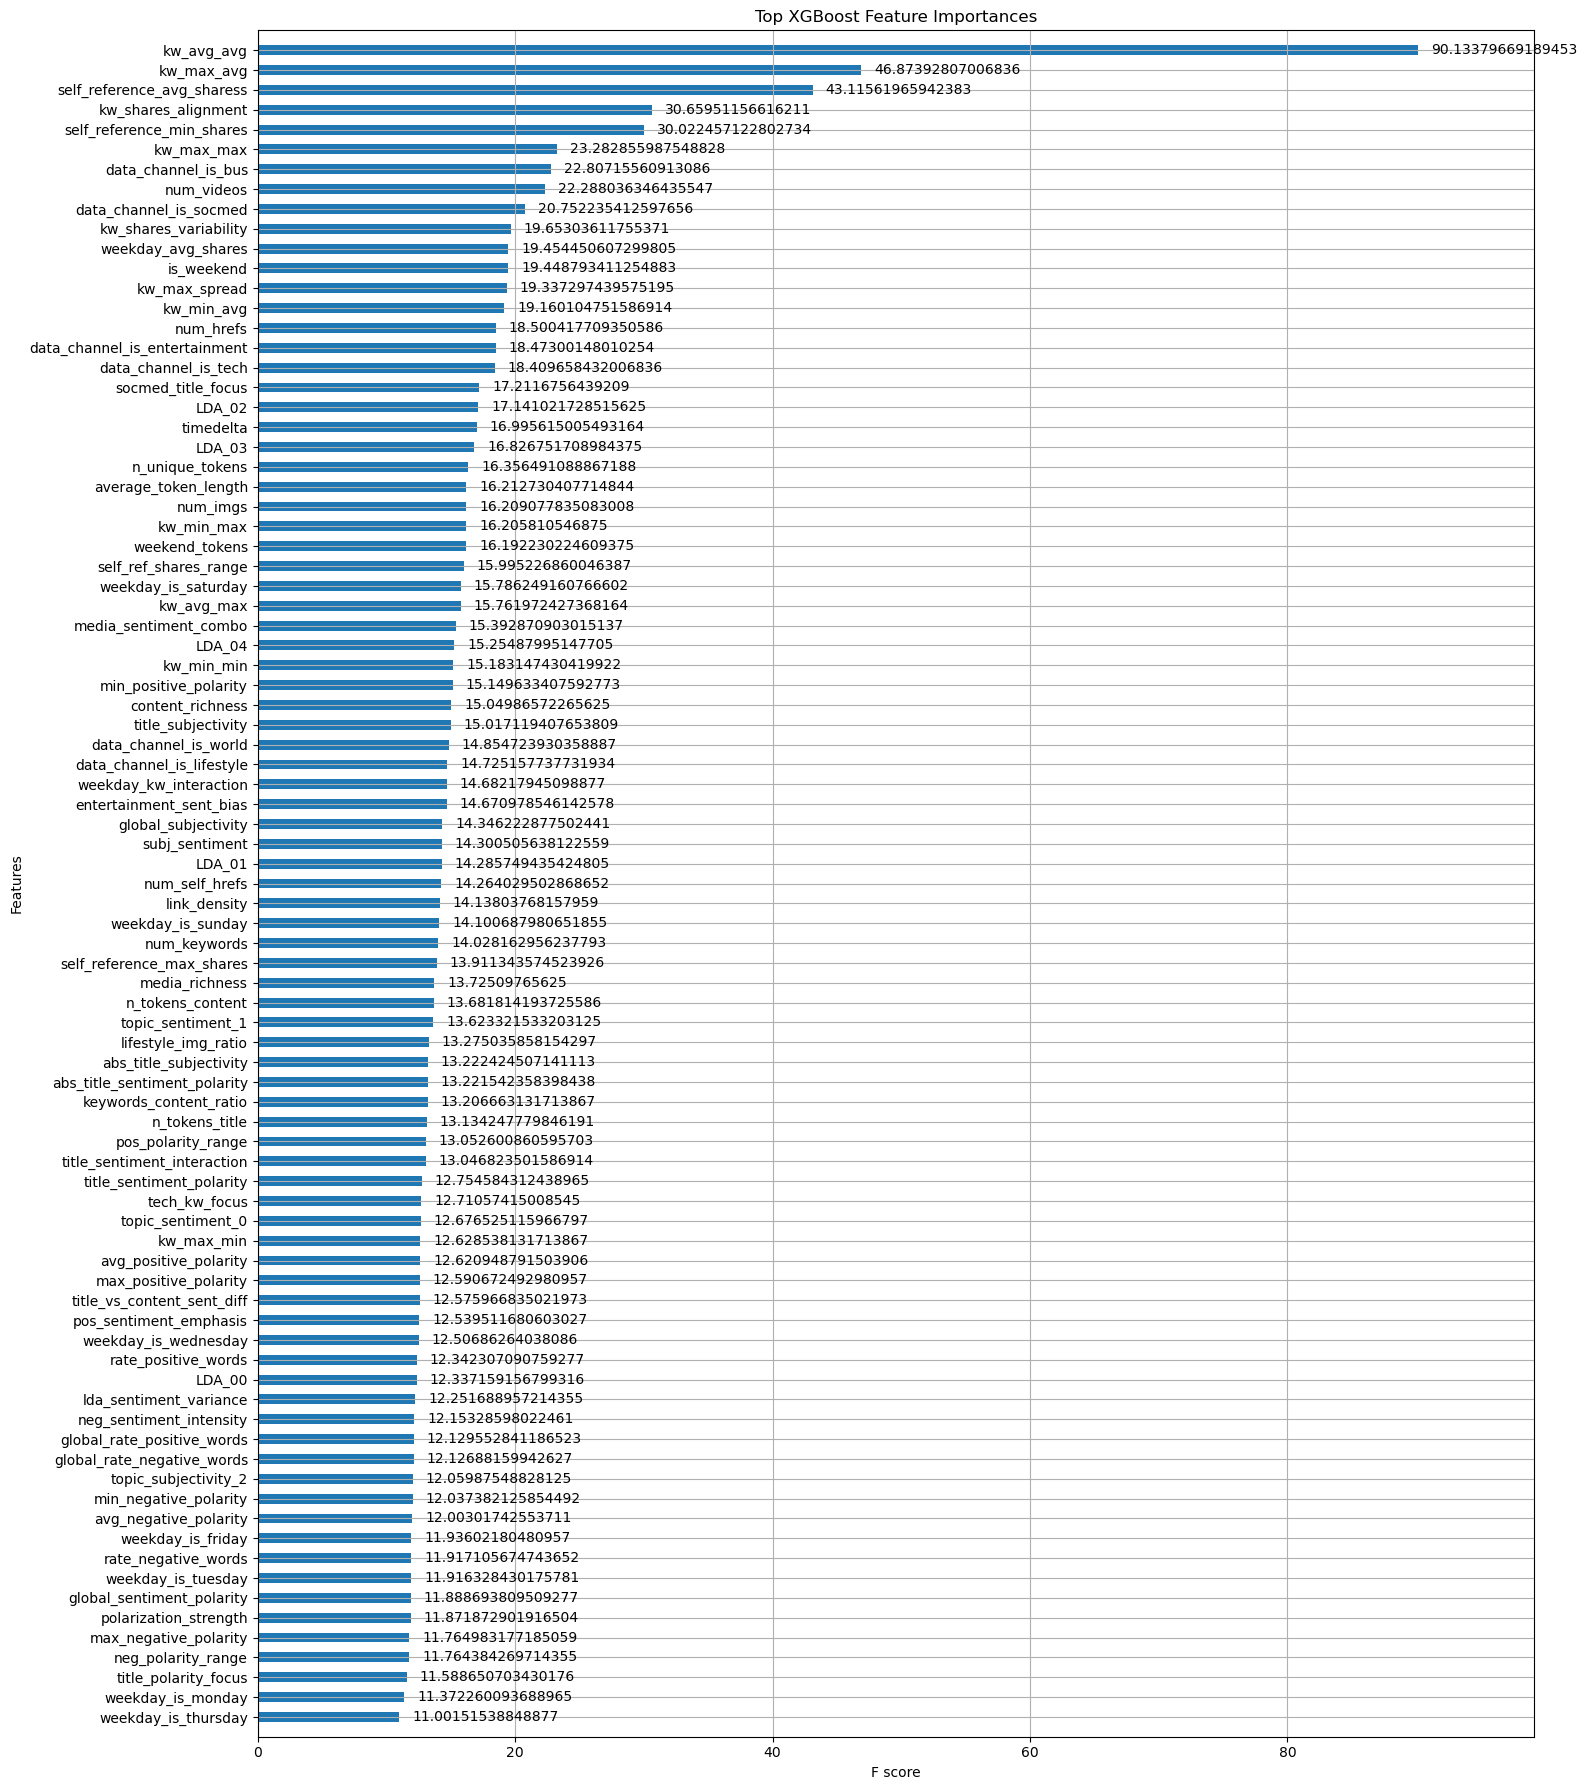

In [ ]:
fig, ax = plt.subplots(figsize=(16, 18))

xgb.plot_importance(
    best_xgb,
    importance_type='gain',
    height=0.5,
    ax=ax
)

plt.title("Top XGBoost Feature Importances")
plt.tight_layout()
plt.show()

It seems like all of them are good to stay for the model. So, I will continue without dropping least important features.

<hr>

### LightGBM

In [ ]:
def objective_lgb(trial, X_cls, y_cls):
    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "random_state": 42,
        "n_jobs": -1,
        "boost_from_average": False,

        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-3, 10.0, log=True),
    }

    clf_lgb = lgb.LGBMClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf_lgb, X_cls, y_cls, cv=cv, scoring="roc_auc", n_jobs=-1)

    return scores.mean()


In [ ]:
study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(lambda trial: objective_lgb(trial, df_fe_train, y), n_trials=50, n_jobs=-1)

[I 2025-04-11 23:27:18,321] A new study created in memory with name: no-name-e3f4b0ef-891b-4af8-9176-aedab9ac17a7


[LightGBM] [Warning] lambda_l1 is set=0.32581250091455527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32581250091455527
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.220430961907124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.220430961907124
[LightGBM] [Warning] bagging_fraction is set=0.6743072271686212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6743072271686212
[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] feature_fraction is set=0.926165670423151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.926165670423151
[LightGBM] [Warning] lambda_l1 is set=0.32581250091455527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32581250091455527
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be 

[I 2025-04-11 23:27:44,156] Trial 1 finished with value: 0.7002914858137343 and parameters: {'n_estimators': 686, 'learning_rate': 0.054560589265838996, 'num_leaves': 23, 'max_depth': 11, 'min_data_in_leaf': 96, 'feature_fraction': 0.926165670423151, 'bagging_fraction': 0.6743072271686212, 'bagging_freq': 6, 'lambda_l1': 0.32581250091455527, 'lambda_l2': 7.220430961907124}. Best is trial 1 with value: 0.7002914858137343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9744972176624727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9744972176624727
[LightGBM] [Warning] bagging_fraction is set=0.7257998313598519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257998313598519
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.8455778743346178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8455778743346178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2025-04-11 23:28:26,052] Trial 0 finished with value: 0.6882165012246385 and parameters: {'n_estimators': 853, 'learning_rate': 0.06529076392268539, 'num_leaves': 110, 'max_depth': 7, 'min_data_in_leaf': 47, 'feature_fraction': 0.855235260992792, 'bagging_fraction': 0.7375947218580723, 'bagging_freq': 3, 'lambda_l1': 0.06479638878220881, 'lambda_l2': 0.0038988195690769466}. Best is trial 1 with value: 0.7002914858137343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.06479638878220881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06479638878220881
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0038988195690769466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038988195690769466
[LightGBM] [Warning] bagging_fraction is set=0.7375947218580723, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7375947218580723
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current 

[I 2025-04-11 23:28:41,726] Trial 2 finished with value: 0.6845435688281996 and parameters: {'n_estimators': 607, 'learning_rate': 0.11475395345586184, 'num_leaves': 59, 'max_depth': 5, 'min_data_in_leaf': 84, 'feature_fraction': 0.9284184388932304, 'bagging_fraction': 0.8143756891631292, 'bagging_freq': 4, 'lambda_l1': 0.024862525898649544, 'lambda_l2': 0.026937233550639903}. Best is trial 1 with value: 0.7002914858137343.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.024862525898649544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024862525898649544
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.026937233550639903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026937233550639903
[LightGBM] [Warning] bagging_fraction is set=0.8143756891631292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8143756891631292
[LightGBM] [Warning] min_data_in_leaf is set=84, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=84
[LightGBM] [Warning] feature_fraction is set=0.9284184388932304, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2025-04-11 23:28:52,458] Trial 7 finished with value: 0.719423002410899 and parameters: {'n_estimators': 374, 'learning_rate': 0.012890583400909114, 'num_leaves': 97, 'max_depth': 11, 'min_data_in_leaf': 63, 'feature_fraction': 0.8455778743346178, 'bagging_fraction': 0.7257998313598519, 'bagging_freq': 3, 'lambda_l1': 0.02723425040339665, 'lambda_l2': 1.9744972176624727}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=5.684695099196098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.684695099196098
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=0.35688995171946575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35688995171946575
[LightGBM] [Warning] bagg

[I 2025-04-11 23:29:03,029] Trial 4 finished with value: 0.7107624987668814 and parameters: {'n_estimators': 718, 'learning_rate': 0.032567294755191975, 'num_leaves': 141, 'max_depth': 5, 'min_data_in_leaf': 59, 'feature_fraction': 0.8190549547012009, 'bagging_fraction': 0.7784180377836458, 'bagging_freq': 7, 'lambda_l1': 1.2119514505230962, 'lambda_l2': 0.030607130926606742}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.4239982521043251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4239982521043251
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.923067274817245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.923067274817245
[LightGBM] [Warning] bagging_fraction is set=0.7728512376904235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7728512376904235
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.9545011493176467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9545011493176467
[LightGBM] [Warning] lambda_l1 is set=0.4239982521043251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4239982521043

[I 2025-04-11 23:29:59,311] Trial 6 finished with value: 0.7091695620826818 and parameters: {'n_estimators': 700, 'learning_rate': 0.028787002127219262, 'num_leaves': 35, 'max_depth': 7, 'min_data_in_leaf': 57, 'feature_fraction': 0.9545011493176467, 'bagging_fraction': 0.7728512376904235, 'bagging_freq': 3, 'lambda_l1': 0.4239982521043251, 'lambda_l2': 3.923067274817245}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.4239982521043251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4239982521043251
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.923067274817245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.923067274817245
[LightGBM] [Warning] bagging_fraction is set=0.7728512376904235, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7728512376904235
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] feature_fraction is set=0.9545011493176467, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9545011493176467
[LightGBM] [Warning] No further splits with positive g

[I 2025-04-11 23:30:13,005] Trial 5 finished with value: 0.7123606800191404 and parameters: {'n_estimators': 240, 'learning_rate': 0.011254267016443695, 'num_leaves': 49, 'max_depth': 8, 'min_data_in_leaf': 84, 'feature_fraction': 0.7618356668955405, 'bagging_fraction': 0.8233027232495074, 'bagging_freq': 5, 'lambda_l1': 0.016268253101066523, 'lambda_l2': 4.869956385103077}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=3.5810954885060444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5810954885060444
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.47869608147417625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47869608147417625
[LightGBM] [Warning] bagging_fraction is set=0.9156178685564862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9156178685564862
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.6200138500833994, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6200138500833994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2025-04-11 23:30:15,422] Trial 3 finished with value: 0.6917126212177201 and parameters: {'n_estimators': 968, 'learning_rate': 0.0711604041197498, 'num_leaves': 75, 'max_depth': 12, 'min_data_in_leaf': 88, 'feature_fraction': 0.9417224779791481, 'bagging_fraction': 0.785446193513018, 'bagging_freq': 9, 'lambda_l1': 5.684695099196098, 'lambda_l2': 0.35688995171946575}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=3.5810954885060444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5810954885060444
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.47869608147417625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.47869608147417625
[LightGBM] [Warning] bagging_fraction is set=0.9156178685564862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9156178685564862
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] feature_fraction is set=0.6200138

[I 2025-04-11 23:30:27,816] Trial 8 finished with value: 0.7070476807127257 and parameters: {'n_estimators': 825, 'learning_rate': 0.0480275539165148, 'num_leaves': 106, 'max_depth': 4, 'min_data_in_leaf': 70, 'feature_fraction': 0.7795338290456668, 'bagging_fraction': 0.7361967730683039, 'bagging_freq': 3, 'lambda_l1': 0.01102118696940014, 'lambda_l2': 0.002599870552427889}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.08102047459071646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08102047459071646
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.023883771995192545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023883771995192545
[LightGBM] [Warning] bagging_fraction is set=0.7896945095420608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7896945095420608
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.9980855165256469, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2025-04-11 23:31:15,831] Trial 9 finished with value: 0.7141001759070237 and parameters: {'n_estimators': 985, 'learning_rate': 0.02148694629064787, 'num_leaves': 83, 'max_depth': 6, 'min_data_in_leaf': 27, 'feature_fraction': 0.6200138500833994, 'bagging_fraction': 0.9156178685564862, 'bagging_freq': 4, 'lambda_l1': 3.5810954885060444, 'lambda_l2': 0.47869608147417625}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=5.093682270662065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.093682270662065
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.003807730741859485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003807730741859485
[LightGBM] [Warning] bagging_fraction is set=0.9049681328982608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9049681328982608
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.7253588427907653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7253588427907653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[I 2025-04-11 23:31:31,101] Trial 10 finished with value: 0.6868334928457883 and parameters: {'n_estimators': 383, 'learning_rate': 0.10958212765570344, 'num_leaves': 71, 'max_depth': 11, 'min_data_in_leaf': 92, 'feature_fraction': 0.9980855165256469, 'bagging_fraction': 0.7896945095420608, 'bagging_freq': 2, 'lambda_l1': 0.08102047459071646, 'lambda_l2': 0.023883771995192545}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=5.093682270662065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.093682270662065
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.003807730741859485, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003807730741859485
[LightGBM] [Warning] bagging_fraction is set=0.9049681328982608, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9049681328982608
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.7253588427907653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7253588427907653
[LightGBM] [Info] Number of positive: 2893, number of negative: 20893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005057 seconds.
You can set `force_row_wis

[I 2025-04-11 23:32:08,141] Trial 11 finished with value: 0.692563215416903 and parameters: {'n_estimators': 530, 'learning_rate': 0.10158821158391765, 'num_leaves': 122, 'max_depth': 12, 'min_data_in_leaf': 79, 'feature_fraction': 0.8716692949751542, 'bagging_fraction': 0.9698576544603066, 'bagging_freq': 4, 'lambda_l1': 0.041147654790963106, 'lambda_l2': 1.7490950188643277}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.32860852581173716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32860852581173716
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.621548123382317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.621548123382317
[LightGBM] [Warning] bagging_fraction is set=0.8920270627387219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8920270627387219
[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] feature_fraction is set=0.8800301158262286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8800301158262286
[LightGBM] [Info] Number of positive: 2893, number o

[I 2025-04-11 23:33:10,013] Trial 12 finished with value: 0.7012008868445024 and parameters: {'n_estimators': 643, 'learning_rate': 0.051866062987085064, 'num_leaves': 118, 'max_depth': 12, 'min_data_in_leaf': 94, 'feature_fraction': 0.7253588427907653, 'bagging_fraction': 0.9049681328982608, 'bagging_freq': 5, 'lambda_l1': 5.093682270662065, 'lambda_l2': 0.003807730741859485}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.0015887170524223684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015887170524223684
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=1.808181801989602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.808181801989602
[LightGBM] [Warning] bagging_fraction is set=0.617268756147075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.617268756147075
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.6943292439629279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6943292439629279
[LightGBM] [Info] Number of positive: 2893, number of negative: 20893
[LightGBM] [Info] Auto-choosing row-wise multi-threadin

[I 2025-04-11 23:33:16,922] Trial 13 finished with value: 0.6953850750840346 and parameters: {'n_estimators': 567, 'learning_rate': 0.06039649756348898, 'num_leaves': 107, 'max_depth': 9, 'min_data_in_leaf': 76, 'feature_fraction': 0.8800301158262286, 'bagging_fraction': 0.8920270627387219, 'bagging_freq': 6, 'lambda_l1': 0.32860852581173716, 'lambda_l2': 8.621548123382317}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0015887170524223684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015887170524223684
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=1.808181801989602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.808181801989602
[LightGBM] [Warning] bagging_fraction is set=0.617268756147075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.617268756147075
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.6943292439629279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6943292439629279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.0015887170524223684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001588

[I 2025-04-11 23:34:06,460] Trial 14 finished with value: 0.6816233736377054 and parameters: {'n_estimators': 479, 'learning_rate': 0.15971020333158004, 'num_leaves': 113, 'max_depth': 11, 'min_data_in_leaf': 31, 'feature_fraction': 0.958224845380542, 'bagging_fraction': 0.6915653995970333, 'bagging_freq': 7, 'lambda_l1': 0.2293753417656214, 'lambda_l2': 0.07586014487696761}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0023676479123532343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0023676479123532343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.6558341759332098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6558341759332098
[LightGBM] [Warning] bagging_fraction is set=0.6010860647981783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6010860647981783
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.6734327837711571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6734327837711571
[LightGBM] [Warning] lambda_l1 is set=0.0023676479123532343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0023676479123532343
[LightGBM] [Warning] bagging_freq is set=1, subsample_fre

[I 2025-04-11 23:34:15,436] Trial 16 finished with value: 0.7101775982087032 and parameters: {'n_estimators': 538, 'learning_rate': 0.04034182037127231, 'num_leaves': 24, 'max_depth': 12, 'min_data_in_leaf': 58, 'feature_fraction': 0.9040423376673061, 'bagging_fraction': 0.8754100644970949, 'bagging_freq': 2, 'lambda_l1': 0.001980997331791615, 'lambda_l2': 0.0077593595249404665}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.0012644437736152206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012644437736152206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.6038924192878783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6038924192878783
[LightGBM] [Warning] bagging_fraction is set=0.9551972936356654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9551972936356654
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6238036040195106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6238036040195106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-04-11 23:34:26,091] Trial 15 finished with value: 0.7171390844344281 and parameters: {'n_estimators': 771, 'learning_rate': 0.01503812652885981, 'num_leaves': 37, 'max_depth': 11, 'min_data_in_leaf': 54, 'feature_fraction': 0.6943292439629279, 'bagging_fraction': 0.617268756147075, 'bagging_freq': 9, 'lambda_l1': 0.0015887170524223684, 'lambda_l2': 1.808181801989602}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0012644437736152206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012644437736152206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.6038924192878783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6038924192878783
[LightGBM] [Warning] bagging_fraction is set=0.9551972936356654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9551972936356654
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6238036040195106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6238036040195106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.001264

[I 2025-04-11 23:35:09,959] Trial 17 finished with value: 0.7176112698857251 and parameters: {'n_estimators': 391, 'learning_rate': 0.011179826839150215, 'num_leaves': 150, 'max_depth': 10, 'min_data_in_leaf': 36, 'feature_fraction': 0.6734327837711571, 'bagging_fraction': 0.6010860647981783, 'bagging_freq': 1, 'lambda_l1': 0.0023676479123532343, 'lambda_l2': 0.6558341759332098}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0013137713555024422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013137713555024422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.42308290238661816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.42308290238661816
[LightGBM] [Warning] bagging_fraction is set=0.906583018340857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.906583018340857
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.640546199034416, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.640546199034416
[LightGBM] [Info] Number of positive: 2894, number of negative: 20893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006277 seconds.
You can set `force_row_w

[I 2025-04-11 23:35:59,506] Trial 18 finished with value: 0.718036775417189 and parameters: {'n_estimators': 443, 'learning_rate': 0.014237805798638809, 'num_leaves': 99, 'max_depth': 9, 'min_data_in_leaf': 20, 'feature_fraction': 0.6238036040195106, 'bagging_fraction': 0.9551972936356654, 'bagging_freq': 1, 'lambda_l1': 0.0012644437736152206, 'lambda_l2': 0.6038924192878783}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0012644437736152206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012644437736152206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.6038924192878783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6038924192878783
[LightGBM] [Warning] bagging_fraction is set=0.9551972936356654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9551972936356654
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6238036040195106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6238036040195106
[LightGBM] [Warning] lambda_l1 is set=0.0018773400495205295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018773400495205295
[LightGBM] [Warning] bagging_freq is set=1, subsample_fre

[I 2025-04-11 23:36:01,966] Trial 19 finished with value: 0.7182814814567433 and parameters: {'n_estimators': 418, 'learning_rate': 0.013578004637276363, 'num_leaves': 94, 'max_depth': 9, 'min_data_in_leaf': 29, 'feature_fraction': 0.640546199034416, 'bagging_fraction': 0.906583018340857, 'bagging_freq': 1, 'lambda_l1': 0.0013137713555024422, 'lambda_l2': 0.42308290238661816}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0018773400495205295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018773400495205295
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.7182798227053953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7182798227053953
[LightGBM] [Warning] bagging_fraction is set=0.624787320278445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624787320278445
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.615791695006011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.615791695006011
[LightGBM] [Info] Number of positive: 2893, number of negative: 20893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008296 seconds.
You can set `force_col_wis

[I 2025-04-11 23:36:51,041] Trial 20 finished with value: 0.7179335064979795 and parameters: {'n_estimators': 477, 'learning_rate': 0.01259750881464675, 'num_leaves': 88, 'max_depth': 9, 'min_data_in_leaf': 22, 'feature_fraction': 0.6251186225639133, 'bagging_fraction': 0.6137133766393952, 'bagging_freq': 1, 'lambda_l1': 0.001005202276108211, 'lambda_l2': 0.4503601970158379}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.003983778094069252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003983778094069252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.727192572805652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.727192572805652
[LightGBM] [Warning] bagging_fraction is set=0.637995458963091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.637995458963091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6496410112330682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6496410112330682
[LightGBM] [Warning] lambda_l1 is set=0.003983778094069252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003983778094069252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will

[I 2025-04-11 23:37:15,796] Trial 22 finished with value: 0.7155265501615388 and parameters: {'n_estimators': 212, 'learning_rate': 0.013964716939518512, 'num_leaves': 93, 'max_depth': 9, 'min_data_in_leaf': 25, 'feature_fraction': 0.6007629002877444, 'bagging_fraction': 0.6005922452640388, 'bagging_freq': 1, 'lambda_l1': 0.0012904755586065333, 'lambda_l2': 0.6703940024295786}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0010936314754116181, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010936314754116181
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=0.8038117402704236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8038117402704236
[LightGBM] [Warning] bagging_fraction is set=0.6002748930326305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6002748930326305
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.6816795018723785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6816795018723785
[LightGBM] [Info] Number of positive: 2893, number of negative: 20893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011693 seconds.
You can set `force_c

[I 2025-04-11 23:37:28,996] Trial 21 finished with value: 0.7189248573784922 and parameters: {'n_estimators': 418, 'learning_rate': 0.01266231790728343, 'num_leaves': 90, 'max_depth': 9, 'min_data_in_leaf': 22, 'feature_fraction': 0.615791695006011, 'bagging_fraction': 0.624787320278445, 'bagging_freq': 1, 'lambda_l1': 0.0018773400495205295, 'lambda_l2': 0.7182798227053953}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.0010936314754116181, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010936314754116181
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=0.8038117402704236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8038117402704236
[LightGBM] [Warning] bagging_fraction is set=0.6002748930326305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6002748930326305
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.6816795018723785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6816795018723785
[LightGBM] [Warning] lambda_l1 is set=0.0010936314754116181, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.

[I 2025-04-11 23:37:42,145] Trial 23 finished with value: 0.7167494162019149 and parameters: {'n_estimators': 260, 'learning_rate': 0.014473885675802179, 'num_leaves': 88, 'max_depth': 9, 'min_data_in_leaf': 20, 'feature_fraction': 0.6496410112330682, 'bagging_fraction': 0.637995458963091, 'bagging_freq': 1, 'lambda_l1': 0.003983778094069252, 'lambda_l2': 0.727192572805652}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.003983778094069252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003983778094069252
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.727192572805652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.727192572805652
[LightGBM] [Warning] bagging_fraction is set=0.637995458963091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.637995458963091
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6496410112330682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6496410112330682
[LightGBM] [Warning] lambda_l1 is set=0.0055022701113411196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0055022701113411196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 wi

[I 2025-04-11 23:38:03,566] Trial 24 finished with value: 0.7171265661627226 and parameters: {'n_estimators': 289, 'learning_rate': 0.010087447749625588, 'num_leaves': 94, 'max_depth': 9, 'min_data_in_leaf': 43, 'feature_fraction': 0.6816795018723785, 'bagging_fraction': 0.6002748930326305, 'bagging_freq': 10, 'lambda_l1': 0.0010936314754116181, 'lambda_l2': 0.8038117402704236}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.006153579862389663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006153579862389663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.17642547020296745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17642547020296745
[LightGBM] [Warning] bagging_fraction is set=0.9871196338638636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9871196338638636
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.6116529102089592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6116529102089592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.006153

[I 2025-04-11 23:38:33,665] Trial 25 finished with value: 0.7172010893490878 and parameters: {'n_estimators': 316, 'learning_rate': 0.010108717668004615, 'num_leaves': 149, 'max_depth': 9, 'min_data_in_leaf': 35, 'feature_fraction': 0.6081379563442376, 'bagging_fraction': 0.6029207366838759, 'bagging_freq': 1, 'lambda_l1': 0.0055022701113411196, 'lambda_l2': 0.5261307172150769}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0057297832530060775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0057297832530060775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.13151265996724354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13151265996724354
[LightGBM] [Warning] bagging_fraction is set=0.992513359284771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.992513359284771
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.6611164978263329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6611164978263329
[LightGBM] [Warning] lambda_l1 is set=0.0057297832530060775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0057297832530060775
[LightGBM] [Warning] bagging_freq is set=1, subsample_fre

[I 2025-04-11 23:38:48,889] Trial 26 finished with value: 0.7164255571889628 and parameters: {'n_estimators': 205, 'learning_rate': 0.016914597429479736, 'num_leaves': 92, 'max_depth': 9, 'min_data_in_leaf': 42, 'feature_fraction': 0.6116529102089592, 'bagging_fraction': 0.9871196338638636, 'bagging_freq': 1, 'lambda_l1': 0.006153579862389663, 'lambda_l2': 0.17642547020296745}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0057297832530060775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0057297832530060775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.13151265996724354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13151265996724354
[LightGBM] [Warning] bagging_fraction is set=0.992513359284771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.992513359284771
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.6611164978263329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6611164978263329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.0057297832530060775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00

[I 2025-04-11 23:39:03,032] Trial 27 finished with value: 0.7168881110741289 and parameters: {'n_estimators': 250, 'learning_rate': 0.019627902597394744, 'num_leaves': 94, 'max_depth': 9, 'min_data_in_leaf': 44, 'feature_fraction': 0.8097323224920877, 'bagging_fraction': 0.8554966080157058, 'bagging_freq': 1, 'lambda_l1': 0.006612338836617609, 'lambda_l2': 0.1804933415213781}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0056983903982522136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0056983903982522136
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.1555851308600956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1555851308600956
[LightGBM] [Warning] bagging_fraction is set=0.9733263818038123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9733263818038123
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] feature_fraction is set=0.6613386355175068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6613386355175068
[LightGBM] [Info] Number of positive: 2893, number of negative: 20893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007264 seconds.
You can set `force_col

[I 2025-04-11 23:39:31,601] Trial 28 finished with value: 0.7167150453407831 and parameters: {'n_estimators': 280, 'learning_rate': 0.01734561421005839, 'num_leaves': 94, 'max_depth': 9, 'min_data_in_leaf': 42, 'feature_fraction': 0.6611164978263329, 'bagging_fraction': 0.992513359284771, 'bagging_freq': 1, 'lambda_l1': 0.0057297832530060775, 'lambda_l2': 0.13151265996724354}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0057297832530060775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0057297832530060775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.13151265996724354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13151265996724354
[LightGBM] [Warning] bagging_fraction is set=0.992513359284771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.992513359284771
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.6611164978263329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6611164978263329
[LightGBM] [Warning] lambda_l1 is set=0.006098194540500912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006098194540500912
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=

[I 2025-04-11 23:40:05,256] Trial 29 finished with value: 0.7168780605356939 and parameters: {'n_estimators': 332, 'learning_rate': 0.01976609142108317, 'num_leaves': 96, 'max_depth': 10, 'min_data_in_leaf': 41, 'feature_fraction': 0.6613386355175068, 'bagging_fraction': 0.9733263818038123, 'bagging_freq': 2, 'lambda_l1': 0.0056983903982522136, 'lambda_l2': 0.1555851308600956}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.006566920460411493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006566920460411493
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.17266392294207822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17266392294207822
[LightGBM] [Warning] bagging_fraction is set=0.6737040635378502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6737040635378502
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.7228507766132136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7228507766132136
[LightGBM] [Warning] No further splits with po

[I 2025-04-11 23:40:31,858] Trial 30 finished with value: 0.7166602512870014 and parameters: {'n_estimators': 311, 'learning_rate': 0.019497007874846723, 'num_leaves': 129, 'max_depth': 10, 'min_data_in_leaf': 41, 'feature_fraction': 0.6712547679112422, 'bagging_fraction': 0.6727423059160142, 'bagging_freq': 2, 'lambda_l1': 0.006098194540500912, 'lambda_l2': 0.13569388523872147}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.006048906745318938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006048906745318938
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.14183968762723706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14183968762723706
[LightGBM] [Warning] bagging_fraction is set=0.8506798762045072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506798762045072
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] feature_fraction is set=0.8225883353603789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8225883353603789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-04-11 23:41:06,676] Trial 31 finished with value: 0.7165309792519245 and parameters: {'n_estimators': 313, 'learning_rate': 0.02044342707602496, 'num_leaves': 131, 'max_depth': 10, 'min_data_in_leaf': 42, 'feature_fraction': 0.7228507766132136, 'bagging_fraction': 0.6737040635378502, 'bagging_freq': 2, 'lambda_l1': 0.006566920460411493, 'lambda_l2': 0.17266392294207822}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.006566920460411493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006566920460411493
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.17266392294207822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17266392294207822
[LightGBM] [Warning] bagging_fraction is set=0.6737040635378502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6737040635378502
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] feature_fraction is set=0.7228507766132136, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7228507766132136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.009551070836044246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009

[I 2025-04-11 23:41:15,957] Trial 32 finished with value: 0.7188216711067286 and parameters: {'n_estimators': 335, 'learning_rate': 0.02026933527362742, 'num_leaves': 69, 'max_depth': 10, 'min_data_in_leaf': 70, 'feature_fraction': 0.8225883353603789, 'bagging_fraction': 0.8506798762045072, 'bagging_freq': 2, 'lambda_l1': 0.006048906745318938, 'lambda_l2': 0.14183968762723706}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.009551070836044246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009551070836044246
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.8253114047434584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8253114047434584
[LightGBM] [Warning] bagging_fraction is set=0.6576765500097135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6576765500097135
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.8328260052163626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8328260052163626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.009551070836044246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00955

[I 2025-04-11 23:41:54,110] Trial 33 finished with value: 0.717259701728364 and parameters: {'n_estimators': 358, 'learning_rate': 0.020256881026386887, 'num_leaves': 128, 'max_depth': 10, 'min_data_in_leaf': 67, 'feature_fraction': 0.7199969237797634, 'bagging_fraction': 0.8588869910156465, 'bagging_freq': 2, 'lambda_l1': 0.007405484629709751, 'lambda_l2': 0.1657966369248344}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.0027217010650624025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027217010650624025
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.7734740940990483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7734740940990483
[LightGBM] [Warning] bagging_fraction is set=0.6808513607381252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6808513607381252
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.726729300438564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.726729300438564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.00272170

[I 2025-04-11 23:42:16,009] Trial 34 finished with value: 0.7156104967741309 and parameters: {'n_estimators': 355, 'learning_rate': 0.01992851403252157, 'num_leaves': 127, 'max_depth': 10, 'min_data_in_leaf': 66, 'feature_fraction': 0.8328260052163626, 'bagging_fraction': 0.6576765500097135, 'bagging_freq': 2, 'lambda_l1': 0.009551070836044246, 'lambda_l2': 1.8253114047434584}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.1299276161452835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1299276161452835
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.8901337844221868, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8901337844221868
[LightGBM] [Warning] bagging_fraction is set=0.7311782807460993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7311782807460993
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] feature_fraction is set=0.7102165278118913, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[I 2025-04-11 23:42:33,662] Trial 35 finished with value: 0.7161488074598179 and parameters: {'n_estimators': 342, 'learning_rate': 0.02435237849414716, 'num_leaves': 128, 'max_depth': 10, 'min_data_in_leaf': 66, 'feature_fraction': 0.726729300438564, 'bagging_fraction': 0.6808513607381252, 'bagging_freq': 2, 'lambda_l1': 0.0027217010650624025, 'lambda_l2': 1.7734740940990483}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.0027217010650624025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027217010650624025
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.7734740940990483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7734740940990483
[LightGBM] [Warning] bagging_fraction is set=0.6808513607381252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6808513607381252
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.726729300438564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.726729300438564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-04-11 23:43:09,745] Trial 36 finished with value: 0.7170512548884312 and parameters: {'n_estimators': 366, 'learning_rate': 0.02547388442039749, 'num_leaves': 129, 'max_depth': 10, 'min_data_in_leaf': 67, 'feature_fraction': 0.7102165278118913, 'bagging_fraction': 0.7311782807460993, 'bagging_freq': 2, 'lambda_l1': 0.1299276161452835, 'lambda_l2': 1.8901337844221868}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0028071994193062167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0028071994193062167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.565537343773008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.565537343773008
[LightGBM] [Warning] bagging_fraction is set=0.9422126611235061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9422126611235061
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.8443365820037879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8443365820037879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.0028071994193062167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0028

[I 2025-04-11 23:43:13,513] Trial 37 finished with value: 0.7173924290189232 and parameters: {'n_estimators': 377, 'learning_rate': 0.02542649621760262, 'num_leaves': 130, 'max_depth': 7, 'min_data_in_leaf': 65, 'feature_fraction': 0.7173833461414553, 'bagging_fraction': 0.7088913115616362, 'bagging_freq': 2, 'lambda_l1': 0.041453531048943844, 'lambda_l2': 1.9980345923947567}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0028071994193062167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0028071994193062167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.565537343773008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.565537343773008
[LightGBM] [Warning] bagging_fraction is set=0.9422126611235061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9422126611235061
[LightGBM] [Warning] min_data_in_leaf is set=66, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=66
[LightGBM] [Warning] feature_fraction is set=0.8443365820037879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8443365820037879
[LightGBM] [Info] Number of positive: 2893, number of negative: 20893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007732 seconds.
You can set `force_row_w

[I 2025-04-11 23:43:42,738] Trial 38 finished with value: 0.7141874821375326 and parameters: {'n_estimators': 419, 'learning_rate': 0.026899683168827536, 'num_leaves': 72, 'max_depth': 8, 'min_data_in_leaf': 66, 'feature_fraction': 0.8384208827814291, 'bagging_fraction': 0.9372883719713226, 'bagging_freq': 3, 'lambda_l1': 0.0026529012878143327, 'lambda_l2': 1.6917971670316487}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.0027616861273377915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027616861273377915
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.6770002905608221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6770002905608221
[LightGBM] [Warning] bagging_fraction is set=0.7312357661652034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7312357661652034
[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] feature_fraction is set=0.8534965102408341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8534965102408341
[LightGBM] [Info] Number of positive: 2893, number of negative: 20893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008675 seconds.
You can set `force_row

[I 2025-04-11 23:44:18,156] Trial 39 finished with value: 0.7134739785781765 and parameters: {'n_estimators': 433, 'learning_rate': 0.025496230527662807, 'num_leaves': 77, 'max_depth': 8, 'min_data_in_leaf': 66, 'feature_fraction': 0.8443365820037879, 'bagging_fraction': 0.9422126611235061, 'bagging_freq': 3, 'lambda_l1': 0.0028071994193062167, 'lambda_l2': 1.565537343773008}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.002997843065855113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002997843065855113
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7011625752893473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7011625752893473
[LightGBM] [Warning] bagging_fraction is set=0.7356634557669088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7356634557669088
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.830663530634645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.830663530634645
[LightGBM] [Warning] No further splits with positi

[I 2025-04-11 23:44:26,942] Trial 40 finished with value: 0.7137519691197823 and parameters: {'n_estimators': 406, 'learning_rate': 0.024480243720491405, 'num_leaves': 74, 'max_depth': 8, 'min_data_in_leaf': 67, 'feature_fraction': 0.8534965102408341, 'bagging_fraction': 0.7312357661652034, 'bagging_freq': 3, 'lambda_l1': 0.0027616861273377915, 'lambda_l2': 1.6770002905608221}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.03162601451162779, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03162601451162779
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.3945531737000838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3945531737000838
[LightGBM] [Warning] bagging_fraction is set=0.7250908587838921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7250908587838921
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.843627105914663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.843627105914663
[LightGBM] [Info] Number of positive: 2893, number of negative: 20893
[LightGBM] [Info] Auto-choosing col-wise multi-threading,

[I 2025-04-11 23:44:58,506] Trial 41 finished with value: 0.7139363153602718 and parameters: {'n_estimators': 430, 'learning_rate': 0.02608205973399886, 'num_leaves': 68, 'max_depth': 8, 'min_data_in_leaf': 51, 'feature_fraction': 0.830663530634645, 'bagging_fraction': 0.7356634557669088, 'bagging_freq': 3, 'lambda_l1': 0.002997843065855113, 'lambda_l2': 1.7011625752893473}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.002997843065855113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002997843065855113
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7011625752893473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7011625752893473
[LightGBM] [Warning] bagging_fraction is set=0.7356634557669088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7356634557669088
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.830663530634645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.830663530634645
[LightGBM] [Warning] lambda_l1 is set=0.031564853587921944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.031564853587921944
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 wi

[I 2025-04-11 23:45:22,777] Trial 42 finished with value: 0.7144094453798233 and parameters: {'n_estimators': 418, 'learning_rate': 0.025848747099150592, 'num_leaves': 69, 'max_depth': 8, 'min_data_in_leaf': 51, 'feature_fraction': 0.843627105914663, 'bagging_fraction': 0.7250908587838921, 'bagging_freq': 3, 'lambda_l1': 0.03162601451162779, 'lambda_l2': 1.3945531737000838}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.025377165038731064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025377165038731064
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.06870979054817154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06870979054817154
[LightGBM] [Warning] bagging_fraction is set=0.8213551437963773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8213551437963773
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.7607140904166707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7607140904166707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.025377

[I 2025-04-11 23:45:41,172] Trial 43 finished with value: 0.7106662405949371 and parameters: {'n_estimators': 436, 'learning_rate': 0.027539208754977236, 'num_leaves': 69, 'max_depth': 8, 'min_data_in_leaf': 51, 'feature_fraction': 0.8532973532318494, 'bagging_fraction': 0.7251235138875645, 'bagging_freq': 3, 'lambda_l1': 0.031564853587921944, 'lambda_l2': 0.06311911637771941}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.020055642307056313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020055642307056313
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.05000831068567122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05000831068567122
[LightGBM] [Warning] bagging_fraction is set=0.8200781395674325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8200781395674325
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.757962099503983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.757962099503983
[LightGBM] [Info] Number of positive: 2893, number of negative: 20893
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010714 seconds.
You can set `force_row_w

[I 2025-04-11 23:46:16,262] Trial 44 finished with value: 0.7104675262092612 and parameters: {'n_estimators': 424, 'learning_rate': 0.034373574058857805, 'num_leaves': 74, 'max_depth': 8, 'min_data_in_leaf': 51, 'feature_fraction': 0.7607140904166707, 'bagging_fraction': 0.8213551437963773, 'bagging_freq': 3, 'lambda_l1': 0.025377165038731064, 'lambda_l2': 0.06870979054817154}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.025377165038731064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025377165038731064
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.06870979054817154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06870979054817154
[LightGBM] [Warning] bagging_fraction is set=0.8213551437963773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8213551437963773
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.7607140904166707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7607140904166707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.023011

[I 2025-04-11 23:46:38,233] Trial 45 finished with value: 0.7184783009102865 and parameters: {'n_estimators': 422, 'learning_rate': 0.01667812746622238, 'num_leaves': 68, 'max_depth': 8, 'min_data_in_leaf': 48, 'feature_fraction': 0.757962099503983, 'bagging_fraction': 0.8200781395674325, 'bagging_freq': 3, 'lambda_l1': 0.020055642307056313, 'lambda_l2': 0.05000831068567122}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.020055642307056313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020055642307056313
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.05000831068567122, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05000831068567122
[LightGBM] [Warning] bagging_fraction is set=0.8200781395674325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8200781395674325
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.757962099503983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.757962099503983
[LightGBM] [Warning] No further splits with posi

[I 2025-04-11 23:47:01,684] Trial 46 finished with value: 0.7086648951962939 and parameters: {'n_estimators': 453, 'learning_rate': 0.037870091030116654, 'num_leaves': 59, 'max_depth': 8, 'min_data_in_leaf': 52, 'feature_fraction': 0.7835800967465314, 'bagging_fraction': 0.8202740726482846, 'bagging_freq': 3, 'lambda_l1': 0.02301150650740951, 'lambda_l2': 0.0746463739587669}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.02301150650740951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02301150650740951
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0746463739587669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0746463739587669
[LightGBM] [Warning] bagging_fraction is set=0.8202740726482846, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8202740726482846
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] feature_fraction is set=0.7835800967465314, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7835800967465314
[LightGBM] [Warning] lambda_l1 is set=0.017430611968246343, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017430611968246343
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 wi

[I 2025-04-11 23:47:34,230] Trial 47 finished with value: 0.7185772595147031 and parameters: {'n_estimators': 463, 'learning_rate': 0.012095810215522761, 'num_leaves': 63, 'max_depth': 8, 'min_data_in_leaf': 51, 'feature_fraction': 0.7863472320909359, 'bagging_fraction': 0.8190715506027398, 'bagging_freq': 3, 'lambda_l1': 0.018817754564257532, 'lambda_l2': 0.05393231704178247}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.040584083850532734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.040584083850532734
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.06831129026761144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06831129026761144
[LightGBM] [Warning] bagging_fraction is set=0.8324090157013541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8324090157013541
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.7766023909048027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7766023909048027
[LightGBM] [Warning] lambda_l1 is set=0.040584083850532734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.040584083850532734
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=

[I 2025-04-11 23:48:23,292] Trial 48 finished with value: 0.7179710846193231 and parameters: {'n_estimators': 473, 'learning_rate': 0.012570171763043064, 'num_leaves': 102, 'max_depth': 11, 'min_data_in_leaf': 51, 'feature_fraction': 0.7748836774628413, 'bagging_fraction': 0.8502202442617103, 'bagging_freq': 4, 'lambda_l1': 0.017430611968246343, 'lambda_l2': 0.2822276143688913}. Best is trial 7 with value: 0.719423002410899.


[LightGBM] [Warning] lambda_l1 is set=0.040584083850532734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.040584083850532734
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.06831129026761144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06831129026761144
[LightGBM] [Warning] bagging_fraction is set=0.8324090157013541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8324090157013541
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] feature_fraction is set=0.7766023909048027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7766023909048027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-04-11 23:48:26,481] Trial 49 finished with value: 0.7185284136913802 and parameters: {'n_estimators': 473, 'learning_rate': 0.012403083588083398, 'num_leaves': 60, 'max_depth': 11, 'min_data_in_leaf': 26, 'feature_fraction': 0.7766023909048027, 'bagging_fraction': 0.8324090157013541, 'bagging_freq': 4, 'lambda_l1': 0.040584083850532734, 'lambda_l2': 0.06831129026761144}. Best is trial 7 with value: 0.719423002410899.


In [37]:
print("Best AUC:", study_lgb.best_value)
print("Best hyperparameters:", study_lgb.best_params)

Best AUC: 0.719423002410899
Best hyperparameters: {'n_estimators': 374, 'learning_rate': 0.012890583400909114, 'num_leaves': 97, 'max_depth': 11, 'min_data_in_leaf': 63, 'feature_fraction': 0.8455778743346178, 'bagging_fraction': 0.7257998313598519, 'bagging_freq': 3, 'lambda_l1': 0.02723425040339665, 'lambda_l2': 1.9744972176624727}


This model with appropriate engineered features achieved AUC score of 0.7194 which is the highest score I could achieve with LightGBM. One recommendation is to increase n_trails to 200-300 because LightGBM learns best in more trials. In this way, AUC score could be improved.

In [38]:
best_params_lgb = study_lgb.best_params

best_params_lgb.update({
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "random_state": 42,
    "boost_from_average": False,
    "n_jobs": -1
})

final_lgb = lgb.LGBMClassifier(**best_params_lgb)
final_lgb.fit(df_fe_train, y)

y_test_proba_lgb = final_lgb.predict_proba(df_fe_test)[:, 1]
submission_lgb = pd.DataFrame({
    'article_id': test_id['article_id'], 
    'score': y_test_proba_lgb
})

submission_lgb.to_csv("submission_lgb_again.csv", index=False)

[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9744972176624727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9744972176624727
[LightGBM] [Warning] bagging_fraction is set=0.7257998313598519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257998313598519
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.8455778743346178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8455778743346178
[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will

(*) It achieved a public score of 0.7333 on leaderboard.

<hr>

### Logistic

I selected Logistic Regression as a strong baseline due to its simplicity, interpretability, and ability to capture linear relationships between features and the target.

In [ ]:
def objective_lr(trial, X_cls, y_cls):
    solver, penalty = trial.suggest_categorical(
        "solver_penalty",
        [
            ("liblinear", "l1"),
            ("liblinear", "l2"),
            ("saga", "l1"),
            ("saga", "l2"),
            ("saga", "elasticnet"),
            ("lbfgs", "l2"),
        ]
    )

    params = {
        "C": trial.suggest_float("C", 1e-4, 100.0, log=True),
        "penalty": penalty,
        "solver": solver,
        "class_weight": trial.suggest_categorical("class_weight", ['balanced', None]),
        "random_state": 42,
        "max_iter": 1000,
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
    }

    # adding l1_ratio for elasticnet only
    if penalty == "elasticnet":
        params["l1_ratio"] = trial.suggest_float("l1_ratio", 0.0, 1.0)

    # adding dual only for liblinear + l2
    if solver == "liblinear" and penalty == "l2":
        params["dual"] = trial.suggest_categorical("dual", [True, False])

    clf_lr = LogisticRegression(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf_lr, X_cls, y_cls, cv=cv, scoring="roc_auc", n_jobs=-1)

    return np.mean(scores)


In [48]:
study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(lambda trial: objective_lr(trial, df_fe_train, y), n_trials=50, n_jobs=-1)

[I 2025-04-12 00:22:41,969] A new study created in memory with name: no-name-0c5d3d56-910a-4cdb-b49d-b7d7445acced
/Users/azizbek.ussenov/anaconda3/envs/mining/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/Users/azizbek.ussenov/anaconda3/envs/mining/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/Users/azizbek.ussenov/anaconda3/envs/mining/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') whic

In [49]:
print("Best AUC:", study_lr.best_value)
print("Best hyperparameters:", study_lr.best_params)

Best AUC: 0.705278996472346
Best hyperparameters: {'solver_penalty': ('liblinear', 'l1'), 'C': 0.12079544099818161, 'class_weight': 'balanced', 'fit_intercept': True}


In [ ]:
best_solver, best_penalty = study_lr.best_params["solver_penalty"]

final_model_lr = LogisticRegression(
    penalty=best_penalty,
    solver=best_solver,
    C=study_lr.best_params["C"],
    class_weight=study_lr.best_params["class_weight"],
    fit_intercept=study_lr.best_params["fit_intercept"],
    max_iter=1000,
    random_state=42
)

final_model_lr.fit(df_fe_train, y)

LogisticRegression(C=0.12079544099818161, class_weight='balanced',
                   max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

(*) I did not submit this model with new engineering features because in previous experiments it did not perform well. So, I did not want to use kaggle submission attempt for this model.

<hr>

### StackingClassifier

I used `Logistic Regression`, `XGBoost`, and `LightGBM` as base learners to combine linear and non-linear modeling capabilities. Logistic Regression captures linear trends, while XGBoost and LightGBM model complex interactions differently, ensuring diversity.
`XGBoost` was chosen as the final estimator in the StackingClassifier due to its strong regularization, robustness to overfitting, and ability to effectively learn from the combined outputs of the base models.

In [61]:
cv_ens = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stacked_model_final = StackingClassifier(
    estimators=[
        ('lr', final_model_lr),
        ('xgb', best_xgb),
        ('lgb', final_lgb)
    ],
    final_estimator=best_xgb,
    cv=cv_ens,
    stack_method='predict_proba',
    passthrough=True,
    n_jobs=-1
)

auc_scores = cross_val_score(stacked_model_final, df_fe_train, y, cv=cv_ens, scoring='roc_auc', n_jobs=-1)


[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9744972176624727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9744972176624727
[LightGBM] [Warning] bagging_fraction is set=0.7257998313598519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257998313598519
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.8455778743346178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8455778743346178
[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will

[13:11:57] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Number of positive: 2894, number of negative: 20893
[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9744972176624727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9744972176624727
[LightGBM] [Warning] bagging_fraction is set=0.7257998313598519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257998313598519
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.8455778743346178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8455778743346178
[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0272342504033

[13:11:57] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[13:11:58] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[13:11:58] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[13:11:58] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[13:12:18] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9744972176624727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9744972176624727
[LightGBM] [Warning] ba

[13:12:19] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9744972176624727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9744972176624727
[LightGBM] [Warning] bagging_fraction is set=0.7257998313598519, subsample=1.0 will be ignored. Cu

[13:12:19] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[13:12:19] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9744972176624727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9744972176624727
[LightGBM] [Warning] bagging_fraction is set=0.7257998313598519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257998313598519
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.8455778743346178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8455778743346178
[LightGBM] [Info] Number of positive: 2315, number of negative: 16714
[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0272342504033

[13:12:22] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[13:12:22] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[13:12:23] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[13:12:23] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[13:12:25] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[13:12:25] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[13:12:26] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[13:12:27] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[13:12:27] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[13:12:29] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[13:12:30] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[13:12:31] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[13:12:31] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[13:12:32] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] [LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[13:12:33] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[13:12:33] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[13:12:34] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[13:12:34] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[13:12:35] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[13:12:36] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[13:12:38] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [62]:
print("Cross-validated AUC of final stacked model:", np.round(auc_scores.max(), 4))

Cross-validated AUC of final stacked model: 0.725


In [63]:
stacked_model_final.fit(df_fe_train, y)

[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9744972176624727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9744972176624727
[LightGBM] [Warning] bagging_fraction is set=0.7257998313598519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257998313598519
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.8455778743346178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8455778743346178
[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will

/Users/azizbek.ussenov/anaconda3/envs/mining/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:16:16] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[13:16:50] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[13:16:50] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[13:16:50] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[13:16:50] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[13:16:50] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('lr',
                                LogisticRegression(C=0.12079544099818161,
                                                   class_weight='balanced',
                                                   max_iter=1000, penalty='l1',
                                                   random_state=42,
                                                   solver='liblinear')),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytr...
                   final_estimator=LGBMClassifier(bagging_fraction=0.7257998313598519,
                                                  bagging_freq=3,
                                                  boost_from_average=False,
                                                  feature_fraction=0.8455778743346178,
                                                  lambda_l1=0.02723425040339665,
                                                  lambda_l2=1.9744972176624727,
                                                  learning_rate=0.012890583400909114,
                                                  max_depth=11, metric='auc',
                                                  min_data_in_leaf=63,
                                                  n_estimators=374, n_jobs=-1,
                                                  num_leaves=97,
                                                  objective='binary',
                                                  random_state=42),
                   n_jobs=-1, passthrough=True, stack_method='predict_proba')

In [64]:
y_pred_proba_stacked = stacked_model_final.predict_proba(df_fe_test)[:, 1]

[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9744972176624727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9744972176624727
[LightGBM] [Warning] bagging_fraction is set=0.7257998313598519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257998313598519
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.8455778743346178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8455778743346178
[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will

In [ ]:
submission_stacked = pd.DataFrame({
    'article_id': test_id['article_id'], 
    'score': y_pred_proba_stacked
})

submission_stacked.to_csv("submission_stacked_again.csv", index=False)

(*) It achieved a public score of 0.7333 on leaderboard.

<hr>

### Ensemble Weighting

I experimented with a weighted averaging ensemble to balance the individual model contributions based on validation AUC scores, which helped mitigate overfitting and improve robustness across different data patterns.

In [ ]:
# function for generating out-of-fold (OOF) predictions
def get_oof_preds(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(y))
    
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train = y.iloc[train_idx]
        
        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        oof_preds[valid_idx] = model_clone.predict_proba(X_valid)[:, 1]
    
    return oof_preds


model_dict = {
    'lr': final_model_lr,
    'xgb': best_xgb,
    'lgb': final_lgb
}

# generating OOF predictions
model_preds = {}
for name, model in model_dict.items():
    print(f"Generating OOF for {name}")
    model_preds[name] = get_oof_preds(model, df_fe_train, y)

# optuna study
def objective_ens_w(trial):
    weights = []
    for model_name in model_preds:
        weights.append(trial.suggest_float(f'w_{model_name}', 0.0, 1.0))
    
    weights = np.array(weights)
    weights = weights / weights.sum()  # normalize weights
    
    blended = np.zeros(len(y))
    for i, model_name in enumerate(model_preds):
        blended += weights[i] * model_preds[model_name]
    
    return roc_auc_score(y, blended)


Generating OOF for lr
Generating OOF for xgb


/Users/azizbek.ussenov/anaconda3/envs/mining/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:36:42] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/azizbek.ussenov/anaconda3/envs/mining/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:36:43] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/azizbek.ussenov/anaconda3/envs/mining/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:36:45] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg,

Generating OOF for lgb
[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9744972176624727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9744972176624727
[LightGBM] [Warning] bagging_fraction is set=0.7257998313598519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257998313598519
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.8455778743346178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8455778743346178
[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3

In [71]:
study_ens_w = optuna.create_study(direction='maximize')
study_ens_w.optimize(objective_ens_w, n_trials=100, n_jobs=-1)


[I 2025-04-12 23:37:05,619] A new study created in memory with name: no-name-7987fc78-990c-4fdc-ac5e-1d24c29aa4dd
[I 2025-04-12 23:37:05,672] Trial 1 finished with value: 0.7227240829741854 and parameters: {'w_lr': 0.23660504836938212, 'w_xgb': 0.46289350873574886, 'w_lgb': 0.7106064926743635}. Best is trial 1 with value: 0.7227240829741854.
[I 2025-04-12 23:37:05,673] Trial 2 finished with value: 0.7225858362805988 and parameters: {'w_lr': 0.09269270366163695, 'w_xgb': 0.26914459817626857, 'w_lgb': 0.7417596943817437}. Best is trial 1 with value: 0.7227240829741854.
[I 2025-04-12 23:37:05,674] Trial 7 finished with value: 0.7214848065412249 and parameters: {'w_lr': 0.40168425374933137, 'w_xgb': 0.3021907481227498, 'w_lgb': 0.7202812700295144}. Best is trial 1 with value: 0.7227240829741854.
[I 2025-04-12 23:37:05,674] Trial 0 finished with value: 0.7218376166765464 and parameters: {'w_lr': 0.5356964734720703, 'w_xgb': 0.5935431167310941, 'w_lgb': 0.8301754505434226}. Best is trial 1 w

In [ ]:
print("✅ Best AUC from weighted ensemble:", study_ens_w.best_value)
print("🎯 Best Weights (normalized):")
total_weight = sum(study_ens_w.best_params.values())
for name in model_preds:
    print(f"{name}: {study_ens_w.best_params[f'w_{name}'] / total_weight:.4f}")

✅ Best AUC from weighted ensemble: 0.7228243142089568
🎯 Best Weights (normalized):
lr: 0.1276
xgb: 0.3996
lgb: 0.4727


In [ ]:
test_preds = {
    'lr': final_model_lr.predict_proba(df_fe_test)[:, 1],
    'xgb': best_xgb.predict_proba(df_fe_test)[:, 1],
    'lgb': final_lgb.predict_proba(df_fe_test)[:, 1]
}

# using best weights from Optuna
weights = {
    'lr': study_ens_w.best_params['w_lr'],
    'xgb': study_ens_w.best_params['w_xgb'],
    'lgb': study_ens_w.best_params['w_lgb']
}

# normalize weights (just in case)
weight_sum = sum(weights.values())
for key in weights:
    weights[key] /= weight_sum

# blending predictions using these weights
final_test_preds = np.zeros(len(df_fe_test))

for model_name in test_preds:
    final_test_preds += weights[model_name] * test_preds[model_name]

[LightGBM] [Warning] lambda_l1 is set=0.02723425040339665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02723425040339665
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9744972176624727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9744972176624727
[LightGBM] [Warning] bagging_fraction is set=0.7257998313598519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257998313598519
[LightGBM] [Warning] min_data_in_leaf is set=63, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=63
[LightGBM] [Warning] feature_fraction is set=0.8455778743346178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8455778743346178


In [76]:
submission_ens_w = pd.DataFrame({
    'article_id': test_id['article_id'], 
    'score': final_test_preds
})

submission_ens_w.to_csv("submission_ens_w.csv", index=False)

(*) It achieved a public score of 0.7385 on leaderboard.

Overall, `Ensemble Weighting` is winner among all other models with highes public Kaggle score. However, its score on training data was a bit lower than `StackingClassifer` but higher than other models. `XGBoost` model alone performed well on test dataset than `StackingClassifier` even though AUC score was lower on train dataset.  